In [1]:
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
import json
import time

directory_path = "D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development"

def write_json_to(json_dict,path):
  json_to_write = json.dumps(json_dict)
  write_file = open(path,"w")
  write_file.write(json_to_write)
  write_file.close()

def read_json_from(path):
  with open(path, "r") as read_file:
    return json.load(read_file)

SEED = 42
proteomeHD_path = f"{directory_path}/data_sources/ProteomeHD/ProteomeHD_v1_1.csv"
proteomeHD_df = pd.read_csv(proteomeHD_path)
proteomeHD_feature_matrix = proteomeHD_df.iloc[:,4:].fillna(0).to_numpy()
proteomeHD_feature_matrix_with_na = proteomeHD_df.iloc[:,4:].to_numpy()
proteomeHD_majority_protein_column = proteomeHD_df['Majority_protein_IDs'].to_numpy()
proteomeHD_simplified_protein_column = proteomeHD_df['Simplified_protein_ID'].to_numpy()

# Loads protein to cell location
protein_to_cell_location_path = f"{directory_path}/data_sources/ProteomeHD/tSNE_map_annotation.csv"
protein_to_cell_location  = pd.read_csv(protein_to_cell_location_path)
proteomeHD_with_cell_location_df = pd.merge(proteomeHD_df,protein_to_cell_location,'left',left_on='Majority_protein_IDs',right_on='ID')
protein_organelle, protein_organelle_categorical = np.unique(proteomeHD_with_cell_location_df['Organelle'].fillna('None').to_numpy(), return_inverse=True)

#Loads Huri
huri_union_path = f"{directory_path}/data_sources/Huri/HI-union-processed.csv"
huri_union_df = pd.read_csv(huri_union_path)
huri_combined = (huri_union_df["Uniprot_Id_1"] + ";" + huri_union_df["Uniprot_Id_2"]).to_numpy()
#Loads Corum
path_to_corum_complexes = f"{directory_path}/data_sources/Corum/allComplexes.txt"
corum_complexes_dataframe = pd.read_csv(path_to_corum_complexes,sep='\t')
all_corum_subunits = corum_complexes_dataframe["subunits(UniProt IDs)"].to_numpy()
corum_pairs_lookup_path = f"{directory_path}/data_sources/Corum/all_corum_complex_pairs.json"
corum_pairs_lookup_json = read_json_from(corum_pairs_lookup_path)

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
organellel_dict = {}
organellel_color = {}
for i in range(len(protein_organelle_categorical)):
  organellel_dict[protein_organelle_categorical[i]] = proteomeHD_with_cell_location_df.loc[i,'Organelle']
organellel_color[0] = "blue"
organellel_color[1] = "yellow"
organellel_color[2] = "black"
organellel_color[3] = "grey"
organellel_color[4] = "purple"
organellel_color[5] = "pink"
organellel_color[6] = "red"
organellel_color[7] = "brown"

In [3]:
organellel_dict

{5: 'Nucleus',
 3: nan,
 1: 'ER',
 0: 'Cytoplasm',
 7: 'Secreted',
 4: 'Nucleolus',
 2: 'Mitochondrion',
 6: 'Ribosome'}

Define custom distance function

In [4]:
# def find_common_observations(vector1,vector2):
#   vector1_bool = np.where(vector1 != 0, 1, 0)
#   vector2_bool = np.where(vector2 != 0, 1, 0)
#   take_indices = np.logical_and(vector1_bool,vector2_bool)
#   take_indices = take_indices.nonzero()[0]
#   x1 = np.take(vector1,take_indices)
#   x2 = np.take(vector2,take_indices)
#   return x1,x2

# 1 - r because the higher the r the closer they are
@nb.njit()
def r_dist(vector1,vector2):
  vector1_bool = np.where(vector1 != 0, 1, 0)
  vector2_bool = np.where(vector2 != 0, 1, 0)
  take_indices = np.logical_and(vector1_bool,vector2_bool)
  take_indices = take_indices.nonzero()[0]
  x1 = np.take(vector1,take_indices)
  x2 = np.take(vector2,take_indices)
  return 1 - np.log2(np.corrcoef(x1,x2)[0,1])

@nb.njit()
def paper_dist(vector1,vector2):
  vector1_bool = np.where(vector1 != 0, 1, 0)
  vector2_bool = np.where(vector2 != 0, 1, 0)
  take_indices = np.logical_and(vector1_bool,vector2_bool)
  take_indices = take_indices.nonzero()[0]
  x1 = np.take(vector1,take_indices)
  x2 = np.take(vector2,take_indices)
  diff = np.where(x1>=x2, x1,x2) - np.where(x1<x2, x1,x2)
  normalizing_factor = np.sum(np.maximum(np.maximum(x1,x2),diff))
  if normalizing_factor == 0:
    return 0
  return np.sum(diff) / normalizing_factor


In [5]:
test1 = np.array([2,-3,4])
test2 = np.array([1,10,5])
paper_dist(test1,test2)

0.75

Set up UMAP parameters

In [6]:
# Parameters used in the UMAP paper
# metric = 'cosine'
# n_neighbors = 10
# min_dist = 0.05
# n_components = 2

# n_neighbor min dist candidates: (30,0.3)
# metric = r_dist
# n_neighbors = 500
# min_dist = 0.3
# n_components = 2

# Using distance function in paper
# metric = paper_dist
# n_neighbors = 20 # 20 was pretty good
# min_dist = 0.5
# n_components = 2

# reducer = umap.UMAP(n_neighbors=n_neighbors,
#                     min_dist=min_dist,
#                     n_components=n_components,
#                     metric=metric,
#                     random_state=SEED)

Runs the transformation (Time varies based on parameters given, but in general small number = faster)

In [8]:
import os
def save_embedding(n_neighbors,min_dist,n_components,metric,random_state):
  embedding_save_path = f"{directory_path}/embeddings/umap/numpy_files/cosine/n_{n_neighbors}_minDist_{min_dist}_com_{n_components}.npy"
  reducer = umap.UMAP(n_neighbors=n_neighbors,
                    min_dist=min_dist/100,
                    n_components=n_components,
                    metric=metric,
                    random_state=random_state)  
  proteomeHD_embedding = reducer.fit_transform(proteomeHD_feature_matrix)
  np.save(embedding_save_path,proteomeHD_embedding)
  return proteomeHD_embedding,embedding_save_path
def save_umap_png(embedding_path):
  with open(embedding_path, 'rb') as embed_f:
    proteomeHD_embedding = np.load(embed_f)
  file_name = os.path.basename(embedding_path)
  params = file_name.replace(".npy","").split("_")
  n_neighbors = params[1]
  min_dist = params[3]
  n_components = params[5]  
  png_save_path = f"{directory_path}/embeddings/umap/images/cosine/n_{n_neighbors}_minDist_{min_dist}_com_{n_components}.png"
  fig = plt.figure()
  ax = fig.add_subplot(111)
  for i in np.unique(protein_organelle_categorical):
    f_matrix = proteomeHD_embedding[np.where(proteomeHD_with_cell_location_df['Organelle'].to_numpy() == organellel_dict[i])]
    f_xs = f_matrix[:,0]
    f_ys = f_matrix[:,1]
    ax.scatter(f_xs,f_ys,c=organellel_color[i],label=organellel_dict[i])
  plt.title(f"n_{n_neighbors}_minDist_{str(int(min_dist)/100)}_com_{n_components}")
  ax.legend()
  plt.savefig(png_save_path)
  plt.clf()

def grid_search(neighbor_search_range,min_dist_search_range,random_state):
  for i in neighbor_search_range:
    for j in min_dist_search_range:
      print(f"i:{i},j:{j}")
      _,embedding_path = save_embedding(i,j,2,'cosine',random_state)
      save_umap_png(embedding_path)

In [8]:
# neighbor_search_range = list(range(10,101,5))
# min_dist_search_range = np.arange(0.05,0.91,0.05)
neighbor_search_range = list(range(20,101,5))
min_dist_search_range = list(range(5,91,5))
grid_search(neighbor_search_range,min_dist_search_range,SEED)

i:20,j:5
i:20,j:10
i:20,j:15
i:20,j:20
i:20,j:25
i:20,j:30
i:20,j:35
i:20,j:40
i:20,j:45
i:20,j:50
i:20,j:55
i:20,j:60
i:20,j:65
i:20,j:70
i:20,j:75
i:20,j:80
i:20,j:85
i:20,j:90
i:25,j:5
i:25,j:10
i:25,j:15


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:20


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:25


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:30


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:35


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:40


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:45


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:50


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:55


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:60


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:65


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:70


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:75


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:80


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:85


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:25,j:90


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:5


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:10


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:15


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:20


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:25


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:30


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:35


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:40


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:45


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:50


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:55


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:60


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:65


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:70


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:75


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:80


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:85


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:30,j:90


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:5


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:10


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:15


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:20


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:25


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:30


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:35


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:40


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:45


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:50


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:55


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:60


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:65


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:70


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:75


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:80


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:85


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:35,j:90


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:5


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:10


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:15


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:20


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:25


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:30


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:35


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:40


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:45


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:50


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:55


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:60


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:65


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:70


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:75


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:80


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:85


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:40,j:90


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:5


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:10


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:15


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:20


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:25


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:30


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:35


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:40


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:45


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:50


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:55


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:60


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:65


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:70


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:75


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:80


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:85


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:45,j:90


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:5


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:10


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:15


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:20


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:25


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:30


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:35


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:40


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:45


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:50


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:55


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:60


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:65


C:\Users\hoyin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


i:50,j:70


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
import itertools
all_embedding_index_combinations = list(itertools.combinations(range(proteomeHD_feature_matrix.shape[0]),2))

In [11]:
import glob
import time
import itertools

def evaluate_embedding(embedding):
    start_time = time.time()
    all_interacting_dist = np.zeros(len(all_embedding_index_combinations))
    all_non_interacting_dist = np.zeros(len(all_embedding_index_combinations))
    for idx in range(len(all_embedding_index_combinations)):
        indices = all_embedding_index_combinations[idx]
        protein1_index = indices[0]
        protein2_index = indices[1]
        protein1_majority_name = proteomeHD_majority_protein_column[protein1_index]
        protein1_simplified_name = proteomeHD_simplified_protein_column[protein1_index]
        protein2_majority_name = proteomeHD_majority_protein_column[protein2_index]
        protein2_simplified_name = proteomeHD_simplified_protein_column[protein2_index]
        dist = paper_dist(embedding[protein1_index,:],embedding[protein2_index,:])
        if protein1_simplified_name in corum_pairs_lookup_json:
            if (protein2_simplified_name in corum_pairs_lookup_json[protein1_simplified_name]):
                all_interacting_dist[idx] = dist
        else:
            all_non_interacting_dist[idx] = dist
        if (idx % 1000000 == 1):
            percent_done = (idx+1) / len(all_embedding_index_combinations)
            print(f"Percent done: {percent_done}")
            time_since_start = time.time() - start_time
            print(f"Time elasped: {time_since_start}")
            print(f"Estimate finishing in: {time_since_start / (percent_done) - time_since_start}")
        if idx == len(all_embedding_index_combinations) - 1:
            interacting_dist_sum = np.sum(all_interacting_dist)
            non_interacting_dist_sum = np.sum(all_non_interacting_dist)
            interacting_dist_average = interacting_dist_sum / np.count_nonzero(all_interacting_dist)
            non_interacting_dist_average = non_interacting_dist_sum / np.count_nonzero(all_non_interacting_dist)
            all_dist_average = (interacting_dist_sum + non_interacting_dist_sum) / len(all_embedding_index_combinations)
            final_score = abs(interacting_dist_average - non_interacting_dist_average) / all_dist_average
            return final_score
        
def evaluate_embeddings_in_directory(path_to_embedding_directory):
    skipped_files = []
    already_done = set()
    path_to_json_directory = f"{directory_path}/embeddings/umap/json_files/cosine/*.json"
    for jname in glob.glob(path_to_json_directory):
        already_done.add(os.path.basename(jname).replace(".json",".npy"))
    for fname in glob.glob(path_to_embedding_directory):
        file_name = os.path.basename(fname)
        params = file_name.replace(".npy","").split("_")
        n_neighbors = params[1]
        min_dist = params[3]
        components = params[5]
        if (file_name not in already_done):
            write_path = f"{directory_path}/embeddings/umap/json_files/cosine/{file_name.replace('.npy','.json')}"
            print(write_path)
            report_json = {}
            embedding = np.load(fname)
            embedding_score = evaluate_embedding(embedding)
            report_json["n_neighbors"] = n_neighbors
            report_json["min_dist"] = min_dist
            report_json["components"] = components
            report_json["score"] = {}
            report_json["score"]["normalized_manhattan_distance_score"] = embedding_score
            write_json_to(report_json,write_path)
        else:
            skipped_files.append(file_name)
    print("All file processed")
    print(f"Skipped Files: {str(skipped_files)}")

In [11]:
embedding_diretory_path = f"{directory_path}/embeddings/umap/numpy_files/cosine/*.npy"
evaluate_embeddings_in_directory(embedding_diretory_path)

D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_10_minDist_10_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 13.302020072937012
Estimate finishing in: 354345868.3639426
Percent done: 0.018769862111050053
Time elasped: 17.731218576431274
Estimate finishing in: 926.9330773851616
Percent done: 0.03753968668245096
Time elasped: 21.8610999584198
Estimate finishing in: 560.4852617292344
Percent done: 0.05630951125385187
Time elasped: 25.73421359062195
Estimate finishing in: 431.2794066237
Percent done: 0.07507933582525278
Time elasped: 29.797993659973145
Estimate finishing in: 367.08875730074396
Percent done: 0.0938491603966537
Time elasped: 34.0019748210907
Estimate finishing in: 328.3025431669368
Percent done: 0.1126189849680546
Time elasped: 37.976104497909546
Estimate finishing in: 299.2326219764217
Percent done: 0.1313888095394555
Time elasped: 41.84838652610779
Estimate finishing in: 276.6596

Percent done: 0.37539652896766734
Time elasped: 78.82271981239319
Estimate finishing in: 131.14917318606908
Percent done: 0.39416635353906826
Time elasped: 82.72201371192932
Estimate finishing in: 127.1437269054525
Percent done: 0.4129361781104692
Time elasped: 86.61390352249146
Estimate finishing in: 123.13740458236634
Percent done: 0.4317060026818701
Time elasped: 90.3991072177887
Estimate finishing in: 119.0005922448222
Percent done: 0.450475827253271
Time elasped: 94.12782406806946
Estimate finishing in: 114.82417373834775
Percent done: 0.46924565182467187
Time elasped: 97.85353064537048
Estimate finishing in: 110.68016650209356
Percent done: 0.4880154763960728
Time elasped: 101.86092829704285
Estimate finishing in: 106.86386266506312
Percent done: 0.5067853009674738
Time elasped: 105.85618996620178
Estimate finishing in: 103.02159272425513
Percent done: 0.5255551255388746
Time elasped: 109.79201626777649
Estimate finishing in: 99.11473952725441
Percent done: 0.5443249501102755
Tim

Percent done: 0.7883326695384874
Time elasped: 163.03653359413147
Estimate finishing in: 43.77531106730791
Percent done: 0.8071024941098883
Time elasped: 166.97023558616638
Estimate finishing in: 39.905888332034664
Percent done: 0.8258723186812892
Time elasped: 170.69824600219727
Estimate finishing in: 35.99017561091543
Percent done: 0.84464214325269
Time elasped: 174.39885115623474
Estimate finishing in: 32.07776447252172
Percent done: 0.863411967824091
Time elasped: 178.12610149383545
Estimate finishing in: 28.178777442156246
Percent done: 0.8821817923954919
Time elasped: 181.8865716457367
Estimate finishing in: 24.291534968591293
Percent done: 0.9009516169668929
Time elasped: 185.66181707382202
Estimate finishing in: 20.411199032041196
Percent done: 0.9197214415382937
Time elasped: 189.46398329734802
Estimate finishing in: 16.53750230513748
Percent done: 0.9384912661096947
Time elasped: 193.29737401008606
Estimate finishing in: 12.66871325181998
Percent done: 0.9572610906810956
Time

Percent done: 0.15015863411085642
Time elasped: 37.71482753753662
Estimate finishing in: 213.45173215355112
Percent done: 0.16892845868225734
Time elasped: 42.31574463844299
Estimate finishing in: 208.17931681260572
Percent done: 0.18769828325365825
Time elasped: 46.37496066093445
Estimate finishing in: 200.69688175044573
Percent done: 0.20646810782505914
Time elasped: 51.37146997451782
Estimate finishing in: 197.43920841870394
Percent done: 0.22523793239646006
Time elasped: 56.7558114528656
Estimate finishing in: 195.22577463701631
Percent done: 0.24400775696786098
Time elasped: 60.9704315662384
Estimate finishing in: 188.9004427202254
Percent done: 0.2627775815392619
Time elasped: 64.82084321975708
Estimate finishing in: 181.8548543038238
Percent done: 0.2815474061106628
Time elasped: 68.48954939842224
Estimate finishing in: 174.77161341798202
Percent done: 0.30031723068206373
Time elasped: 72.58746004104614
Estimate finishing in: 169.11515514420165
Percent done: 0.3190870552534646
T

Percent done: 0.5630947746816765
Time elasped: 118.84366726875305
Estimate finishing in: 92.21079924789444
Percent done: 0.5818645992530773
Time elasped: 122.61283302307129
Estimate finishing in: 88.11116218211188
Percent done: 0.6006344238244783
Time elasped: 126.51820969581604
Estimate finishing in: 84.12274706158104
Percent done: 0.6194042483958792
Time elasped: 130.24490404129028
Estimate finishing in: 80.02957240700007
Percent done: 0.6381740729672801
Time elasped: 134.0797369480133
Estimate finishing in: 76.01926679964868
Percent done: 0.656943897538681
Time elasped: 137.88093638420105
Estimate finishing in: 72.00142480491797
Percent done: 0.675713722110082
Time elasped: 141.8051986694336
Estimate finishing in: 68.05467841965682
Percent done: 0.6944835466814828
Time elasped: 146.04212617874146
Estimate finishing in: 64.24669473946247
Percent done: 0.7132533712528837
Time elasped: 149.9321756362915
Estimate finishing in: 60.276680962485244
Percent done: 0.7320231958242847
Time ela

Percent done: 0.9760309152524964
Time elasped: 231.9297161102295
Estimate finishing in: 5.69566284636835
Percent done: 0.9948007398238974
Time elasped: 235.55396342277527
Estimate finishing in: 1.2311071879218503
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_10_minDist_45_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.00802922248840332
Estimate finishing in: 213886.4472719431
Percent done: 0.018769862111050053
Time elasped: 3.773242950439453
Estimate finishing in: 197.25343098650427
Percent done: 0.03753968668245096
Time elasped: 7.7487568855285645
Estimate finishing in: 198.66630861769394
Percent done: 0.05630951125385187
Time elasped: 11.697159767150879
Estimate finishing in: 196.03257374835235
Percent done: 0.07507933582525278
Time elasped: 15.7457914352417
Estimate finishing in: 193.97624808692512
Percent done: 0.0938491603966537
Time elasped: 19.446040391921997
Estimate finishing in:

Percent done: 0.3378568798248655
Time elasped: 73.82695841789246
Estimate finishing in: 144.68852203099482
Percent done: 0.3566267043962664
Time elasped: 78.02465534210205
Estimate finishing in: 140.76057408761787
Percent done: 0.37539652896766734
Time elasped: 82.85745286941528
Estimate finishing in: 137.86236331341294
Percent done: 0.39416635353906826
Time elasped: 86.69189119338989
Estimate finishing in: 133.24542820238477
Percent done: 0.4129361781104692
Time elasped: 91.37272500991821
Estimate finishing in: 129.90293416827583
Percent done: 0.4317060026818701
Time elasped: 95.62459015846252
Estimate finishing in: 125.87937217798327
Percent done: 0.450475827253271
Time elasped: 99.36481666564941
Estimate finishing in: 121.2126497691556
Percent done: 0.46924565182467187
Time elasped: 103.20625901222229
Estimate finishing in: 116.73453023303233
Percent done: 0.4880154763960728
Time elasped: 107.217857837677
Estimate finishing in: 112.48389963416824
Percent done: 0.5067853009674738
Tim

Percent done: 0.7320231958242847
Time elasped: 147.49102640151978
Estimate finishing in: 53.99306213947179
Percent done: 0.7507930203956855
Time elasped: 151.17561054229736
Estimate finishing in: 50.178965799694026
Percent done: 0.7695628449670865
Time elasped: 154.9271161556244
Estimate finishing in: 46.391226028957675
Percent done: 0.7883326695384874
Time elasped: 158.79438066482544
Estimate finishing in: 42.63629295902456
Percent done: 0.8071024941098883
Time elasped: 162.55899119377136
Estimate finishing in: 38.85160086870181
Percent done: 0.8258723186812892
Time elasped: 166.3290627002716
Estimate finishing in: 35.06897297412584
Percent done: 0.84464214325269
Time elasped: 170.05173635482788
Estimate finishing in: 31.2781850956506
Percent done: 0.863411967824091
Time elasped: 173.71674966812134
Estimate finishing in: 27.48123708889554
Percent done: 0.8821817923954919
Time elasped: 177.43496417999268
Estimate finishing in: 23.697008514867264
Percent done: 0.9009516169668929
Time el

Percent done: 0.0938491603966537
Time elasped: 18.6942298412323
Estimate finishing in: 180.50019834780096
Percent done: 0.1126189849680546
Time elasped: 22.478713274002075
Estimate finishing in: 177.1209659486296
Percent done: 0.1313888095394555
Time elasped: 26.336711168289185
Estimate finishing in: 174.11195154967524
Percent done: 0.15015863411085642
Time elasped: 30.14246964454651
Estimate finishing in: 170.59503588106628
Percent done: 0.16892845868225734
Time elasped: 33.84429860115051
Estimate finishing in: 166.50263444468567
Percent done: 0.18769828325365825
Time elasped: 37.80369853973389
Estimate finishing in: 163.60303723016872
Percent done: 0.20646810782505914
Time elasped: 41.5254967212677
Estimate finishing in: 159.5975588377649
Percent done: 0.22523793239646006
Time elasped: 45.27964210510254
Estimate finishing in: 155.7506267458922
Percent done: 0.24400775696786098
Time elasped: 48.94453763961792
Estimate finishing in: 151.6414529363479
Percent done: 0.2627775815392619
Ti

Percent done: 0.5067853009674738
Time elasped: 101.74496221542358
Estimate finishing in: 99.02045466069399
Percent done: 0.5255551255388746
Time elasped: 105.4766891002655
Estimate finishing in: 95.21907805092658
Percent done: 0.5443249501102755
Time elasped: 109.18252897262573
Estimate finishing in: 91.4008338706654
Percent done: 0.5630947746816765
Time elasped: 112.88785552978516
Estimate finishing in: 87.58968502917648
Percent done: 0.5818645992530773
Time elasped: 116.53114056587219
Estimate finishing in: 83.74077959469409
Percent done: 0.6006344238244783
Time elasped: 120.4028730392456
Estimate finishing in: 80.05662156080183
Percent done: 0.6194042483958792
Time elasped: 125.41427826881409
Estimate finishing in: 77.06137247722052
Percent done: 0.6381740729672801
Time elasped: 129.8267114162445
Estimate finishing in: 73.60792642887657
Percent done: 0.656943897538681
Time elasped: 134.92708134651184
Estimate finishing in: 70.45892170798385
Percent done: 0.675713722110082
Time elasp

Percent done: 0.9197214415382937
Time elasped: 187.5296185016632
Estimate finishing in: 16.36865985967168
Percent done: 0.9384912661096947
Time elasped: 191.24399709701538
Estimate finishing in: 12.534134893252912
Percent done: 0.9572610906810956
Time elasped: 195.0725839138031
Estimate finishing in: 8.709420612264154
Percent done: 0.9760309152524964
Time elasped: 199.17017674446106
Estimate finishing in: 4.89116355943321
Percent done: 0.9948007398238974
Time elasped: 203.35282635688782
Estimate finishing in: 1.0628100778880025
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_10_minDist_75_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.00501704216003418
Estimate finishing in: 133646.48008859158
Percent done: 0.018769862111050053
Time elasped: 4.41278862953186
Estimate finishing in: 230.68689422503724
Percent done: 0.03753968668245096
Time elasped: 9.020992517471313
Estimate finishing in: 231

Percent done: 0.2815474061106628
Time elasped: 58.6607403755188
Estimate finishing in: 149.69046124223672
Percent done: 0.30031723068206373
Time elasped: 62.7627854347229
Estimate finishing in: 146.22550768512096
Percent done: 0.3190870552534646
Time elasped: 66.50806784629822
Estimate finishing in: 141.92429175997913
Percent done: 0.3378568798248655
Time elasped: 70.23770928382874
Estimate finishing in: 137.65419251860837
Percent done: 0.3566267043962664
Time elasped: 73.98931074142456
Estimate finishing in: 133.48060059536417
Percent done: 0.37539652896766734
Time elasped: 77.72791028022766
Estimate finishing in: 129.32757447339486
Percent done: 0.39416635353906826
Time elasped: 81.44898319244385
Estimate finishing in: 125.18707912273024
Percent done: 0.4129361781104692
Time elasped: 85.40184450149536
Estimate finishing in: 121.41424241121047
Percent done: 0.4317060026818701
Time elasped: 89.27641153335571
Estimate finishing in: 117.52268548810659
Percent done: 0.450475827253271
Time

Percent done: 0.6944835466814828
Time elasped: 139.3599715232849
Estimate finishing in: 61.307088465683876
Percent done: 0.7132533712528837
Time elasped: 143.23985075950623
Estimate finishing in: 57.58619021369597
Percent done: 0.7320231958242847
Time elasped: 147.0438985824585
Estimate finishing in: 53.82937896017694
Percent done: 0.7507930203956855
Time elasped: 150.7809247970581
Estimate finishing in: 50.04795973038864
Percent done: 0.7695628449670865
Time elasped: 154.6427640914917
Estimate finishing in: 46.306079921508484
Percent done: 0.7883326695384874
Time elasped: 158.60188174247742
Estimate finishing in: 42.584606996252035
Percent done: 0.8071024941098883
Time elasped: 162.308926820755
Estimate finishing in: 38.79183548051523
Percent done: 0.8258723186812892
Time elasped: 165.8861117362976
Estimate finishing in: 34.97558078437689
Percent done: 0.84464214325269
Time elasped: 169.4709551334381
Estimate finishing in: 31.171360061504515
Percent done: 0.863411967824091
Time elaspe

Percent done: 0.05630951125385187
Time elasped: 11.026505470275879
Estimate finishing in: 184.79308565646485
Percent done: 0.07507933582525278
Time elasped: 14.682840347290039
Estimate finishing in: 180.88149417831582
Percent done: 0.0938491603966537
Time elasped: 18.307865619659424
Estimate finishing in: 176.76969865775325
Percent done: 0.1126189849680546
Time elasped: 21.98079824447632
Estimate finishing in: 173.19764569826896
Percent done: 0.1313888095394555
Time elasped: 25.67436909675598
Estimate finishing in: 169.7332092712182
Percent done: 0.15015863411085642
Time elasped: 29.353466987609863
Estimate finishing in: 166.12957773654043
Percent done: 0.16892845868225734
Time elasped: 33.02629613876343
Estimate finishing in: 162.4783358006281
Percent done: 0.18769828325365825
Time elasped: 36.743425607681274
Estimate finishing in: 159.01449487380583
Percent done: 0.20646810782505914
Time elasped: 40.4737663269043
Estimate finishing in: 155.55537712414048
Percent done: 0.2252379323964

Percent done: 0.450475827253271
Time elasped: 90.15487933158875
Estimate finishing in: 109.97767801626861
Percent done: 0.46924565182467187
Time elasped: 93.78159213066101
Estimate finishing in: 106.07447849245347
Percent done: 0.4880154763960728
Time elasped: 97.48055458068848
Estimate finishing in: 102.26834539389628
Percent done: 0.5067853009674738
Time elasped: 101.11773347854614
Estimate finishing in: 98.41002173753506
Percent done: 0.5255551255388746
Time elasped: 104.7845344543457
Estimate finishing in: 94.59423546423429
Percent done: 0.5443249501102755
Time elasped: 108.74141931533813
Estimate finishing in: 91.03156425506052
Percent done: 0.5630947746816765
Time elasped: 112.7510917186737
Estimate finishing in: 87.48356999065064
Percent done: 0.5818645992530773
Time elasped: 116.37750744819641
Estimate finishing in: 83.63037685613631
Percent done: 0.6006344238244783
Time elasped: 120.02254843711853
Estimate finishing in: 79.80374135973864
Percent done: 0.6194042483958792
Time e

Percent done: 0.863411967824091
Time elasped: 170.75837397575378
Estimate finishing in: 27.013234872901393
Percent done: 0.8821817923954919
Time elasped: 174.44044995307922
Estimate finishing in: 23.29708153620777
Percent done: 0.9009516169668929
Time elasped: 178.11978220939636
Estimate finishing in: 19.582046451555698
Percent done: 0.9197214415382937
Time elasped: 181.7996654510498
Estimate finishing in: 15.868516718301464
Percent done: 0.9384912661096947
Time elasped: 185.47415685653687
Estimate finishing in: 12.155979463621378
Percent done: 0.9572610906810956
Time elasped: 189.0892789363861
Estimate finishing in: 8.442283536134568
Percent done: 0.9760309152524964
Time elasped: 192.64990377426147
Estimate finishing in: 4.731040582837608
Percent done: 0.9948007398238974
Time elasped: 196.30346298217773
Estimate finishing in: 1.025967047124368
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_15_minDist_25_

Percent done: 0.22523793239646006
Time elasped: 44.934048652648926
Estimate finishing in: 154.56187183714124
Percent done: 0.24400775696786098
Time elasped: 49.187562227249146
Estimate finishing in: 152.3943990942829
Percent done: 0.2627775815392619
Time elasped: 53.12652564048767
Estimate finishing in: 149.04645018678997
Percent done: 0.2815474061106628
Time elasped: 57.202139377593994
Estimate finishing in: 145.9684036147665
Percent done: 0.30031723068206373
Time elasped: 61.14865493774414
Estimate finishing in: 142.4648866458231
Percent done: 0.3190870552534646
Time elasped: 64.9761528968811
Estimate finishing in: 138.65527566504457
Percent done: 0.3378568798248655
Time elasped: 68.8073046207428
Estimate finishing in: 134.85083801175404
Percent done: 0.3566267043962664
Time elasped: 72.65626072883606
Estimate finishing in: 131.07570839511357
Percent done: 0.37539652896766734
Time elasped: 76.4472246170044
Estimate finishing in: 127.19670578169342
Percent done: 0.39416635353906826
Ti

Percent done: 0.6381740729672801
Time elasped: 132.50646686553955
Estimate finishing in: 75.12726894173338
Percent done: 0.656943897538681
Time elasped: 136.10897207260132
Estimate finishing in: 71.07610504364845
Percent done: 0.675713722110082
Time elasped: 139.7441964149475
Estimate finishing in: 67.06556908539181
Percent done: 0.6944835466814828
Time elasped: 143.40483498573303
Estimate finishing in: 63.08650044039487
Percent done: 0.7132533712528837
Time elasped: 147.49509024620056
Estimate finishing in: 59.29690848927578
Percent done: 0.7320231958242847
Time elasped: 151.42270374298096
Estimate finishing in: 55.43235851016732
Percent done: 0.7507930203956855
Time elasped: 155.07307720184326
Estimate finishing in: 51.472632453417134
Percent done: 0.7695628449670865
Time elasped: 158.81334733963013
Estimate finishing in: 47.55491534127208
Percent done: 0.7883326695384874
Time elasped: 162.4478235244751
Estimate finishing in: 43.617242407115356
Percent done: 0.8071024941098883
Time e

Percent done: 3.753964914280182e-08
Time elasped: 0.010010242462158203
Estimate finishing in: 266657.8488333225
Percent done: 0.018769862111050053
Time elasped: 3.8745291233062744
Estimate finishing in: 202.5483577568957
Percent done: 0.03753968668245096
Time elasped: 7.550201892852783
Estimate finishing in: 193.57566142934562
Percent done: 0.05630951125385187
Time elasped: 11.249492645263672
Estimate finishing in: 188.53012530505455
Percent done: 0.07507933582525278
Time elasped: 15.011662244796753
Estimate finishing in: 184.93233139596228
Percent done: 0.0938491603966537
Time elasped: 18.725995779037476
Estimate finishing in: 180.80691106735316
Percent done: 0.1126189849680546
Time elasped: 22.353102922439575
Estimate finishing in: 176.1312194924733
Percent done: 0.1313888095394555
Time elasped: 26.14030647277832
Estimate finishing in: 172.81352045057542
Percent done: 0.15015863411085642
Time elasped: 29.82850694656372
Estimate finishing in: 168.81812515147777
Percent done: 0.1689284

Percent done: 0.39416635353906826
Time elasped: 76.80407738685608
Estimate finishing in: 118.04785935828153
Percent done: 0.4129361781104692
Time elasped: 80.45696544647217
Estimate finishing in: 114.38419817990359
Percent done: 0.4317060026818701
Time elasped: 84.09537386894226
Estimate finishing in: 110.70241292697881
Percent done: 0.450475827253271
Time elasped: 87.74479413032532
Estimate finishing in: 107.03767547595737
Percent done: 0.46924565182467187
Time elasped: 91.40486073493958
Estimate finishing in: 103.38620526537346
Percent done: 0.4880154763960728
Time elasped: 95.01040935516357
Estimate finishing in: 99.67687813990193
Percent done: 0.5067853009674738
Time elasped: 98.66075539588928
Estimate finishing in: 96.01883615410611
Percent done: 0.5255551255388746
Time elasped: 102.24959325790405
Estimate finishing in: 92.3058173720714
Percent done: 0.5443249501102755
Time elasped: 105.84837865829468
Estimate finishing in: 88.6096902522903
Percent done: 0.5630947746816765
Time el

Percent done: 0.8071024941098883
Time elasped: 159.83532309532166
Estimate finishing in: 38.200644160108254
Percent done: 0.8258723186812892
Time elasped: 163.68514919281006
Estimate finishing in: 34.51152781190439
Percent done: 0.84464214325269
Time elasped: 167.3597321510315
Estimate finishing in: 30.783035751283307
Percent done: 0.863411967824091
Time elasped: 171.05472087860107
Estimate finishing in: 27.060115668871077
Percent done: 0.8821817923954919
Time elasped: 174.857013463974
Estimate finishing in: 23.35271492904147
Percent done: 0.9009516169668929
Time elasped: 178.7145972251892
Estimate finishing in: 19.647438937021718
Percent done: 0.9197214415382937
Time elasped: 182.42593121528625
Estimate finishing in: 15.92318078341529
Percent done: 0.9384912661096947
Time elasped: 186.12305974960327
Estimate finishing in: 12.19850857050983
Percent done: 0.9572610906810956
Time elasped: 189.77664518356323
Estimate finishing in: 8.472972429679885
Percent done: 0.9760309152524964
Time el

Percent done: 0.16892845868225734
Time elasped: 36.13755011558533
Estimate finishing in: 177.78466522622125
Percent done: 0.18769828325365825
Time elasped: 40.26116585731506
Estimate finishing in: 174.23821665917563
Percent done: 0.20646810782505914
Time elasped: 43.97484016418457
Estimate finishing in: 169.01127487032014
Percent done: 0.22523793239646006
Time elasped: 47.81083369255066
Estimate finishing in: 164.45729176863864
Percent done: 0.24400775696786098
Time elasped: 51.723899602890015
Estimate finishing in: 160.25255657879904
Percent done: 0.2627775815392619
Time elasped: 55.670915842056274
Estimate finishing in: 156.1847360592777
Percent done: 0.2815474061106628
Time elasped: 59.50340485572815
Estimate finishing in: 151.84077223230443
Percent done: 0.30031723068206373
Time elasped: 63.663055658340454
Estimate finishing in: 148.32296829956724
Percent done: 0.3190870552534646
Time elasped: 67.33852362632751
Estimate finishing in: 143.6964353845845
Percent done: 0.33785687982486

Percent done: 0.5630947746816765
Time elasped: 142.93053793907166
Estimate finishing in: 110.89980175795685
Percent done: 0.5818645992530773
Time elasped: 146.95223999023438
Estimate finishing in: 105.60177374229497
Percent done: 0.6006344238244783
Time elasped: 150.81412076950073
Estimate finishing in: 100.27724993350898
Percent done: 0.6194042483958792
Time elasped: 154.67394137382507
Estimate finishing in: 95.04010526759947
Percent done: 0.6381740729672801
Time elasped: 158.57145237922668
Estimate finishing in: 89.90534900809138
Percent done: 0.656943897538681
Time elasped: 163.21904635429382
Estimate finishing in: 85.23298579915723
Percent done: 0.675713722110082
Time elasped: 167.24820733070374
Estimate finishing in: 80.26520235473251
Percent done: 0.6944835466814828
Time elasped: 171.61910676956177
Estimate finishing in: 75.49849247325076
Percent done: 0.7132533712528837
Time elasped: 175.63623476028442
Estimate finishing in: 70.61038928548214
Percent done: 0.7320231958242847
Tim

Percent done: 0.9760309152524964
Time elasped: 205.67822551727295
Estimate finishing in: 5.0509863377271245
Percent done: 0.9948007398238974
Time elasped: 209.16560554504395
Estimate finishing in: 1.093190183305694
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_15_minDist_75_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 1.5692460536956787
Estimate finishing in: 41802361.785995364
Percent done: 0.018769862111050053
Time elasped: 39.17872643470764
Estimate finishing in: 2048.142224721488
Percent done: 0.03753968668245096
Time elasped: 72.79118728637695
Estimate finishing in: 1866.255025382344
Percent done: 0.05630951125385187
Time elasped: 77.99184131622314
Estimate finishing in: 1307.064423239582
Percent done: 0.07507933582525278
Time elasped: 82.30484652519226
Estimate finishing in: 1013.9334941649392
Percent done: 0.0938491603966537
Time elasped: 86.60149550437927
Estimate finishing in: 83

Percent done: 0.3378568798248655
Time elasped: 64.89181447029114
Estimate finishing in: 127.17713053366745
Percent done: 0.3566267043962664
Time elasped: 68.33627557754517
Estimate finishing in: 123.28222840754393
Percent done: 0.37539652896766734
Time elasped: 71.78800439834595
Estimate finishing in: 119.44446276314184
Percent done: 0.39416635353906826
Time elasped: 75.23505401611328
Estimate finishing in: 115.63627059240957
Percent done: 0.4129361781104692
Time elasped: 78.70031309127808
Estimate finishing in: 111.88679761284646
Percent done: 0.4317060026818701
Time elasped: 82.17522120475769
Estimate finishing in: 108.1747407931386
Percent done: 0.450475827253271
Time elasped: 85.67894077301025
Estimate finishing in: 104.51759273563235
Percent done: 0.46924565182467187
Time elasped: 89.17146134376526
Estimate finishing in: 100.86005199476031
Percent done: 0.4880154763960728
Time elasped: 92.79542589187622
Estimate finishing in: 97.35310500545862
Percent done: 0.5067853009674738
Time

Percent done: 0.7507930203956855
Time elasped: 138.9447250366211
Estimate finishing in: 46.119229025437136
Percent done: 0.7695628449670865
Time elasped: 142.40313053131104
Estimate finishing in: 42.6410558696079
Percent done: 0.7883326695384874
Time elasped: 145.81635355949402
Estimate finishing in: 39.15169253817578
Percent done: 0.8071024941098883
Time elasped: 149.3228931427002
Estimate finishing in: 35.68817327381572
Percent done: 0.8258723186812892
Time elasped: 152.81650257110596
Estimate finishing in: 32.219972334743375
Percent done: 0.84464214325269
Time elasped: 156.29273986816406
Estimate finishing in: 28.747446815258684
Percent done: 0.863411967824091
Time elasped: 159.73658108711243
Estimate finishing in: 25.26963499496148
Percent done: 0.8821817923954919
Time elasped: 163.1712625026703
Estimate finishing in: 21.792045410987953
Percent done: 0.9009516169668929
Time elasped: 166.62924194335938
Estimate finishing in: 18.318804994307072
Percent done: 0.9197214415382937
Time e

Percent done: 0.1126189849680546
Time elasped: 20.717504024505615
Estimate finishing in: 163.243521999502
Percent done: 0.1313888095394555
Time elasped: 24.201029777526855
Estimate finishing in: 159.99296560424415
Percent done: 0.15015863411085642
Time elasped: 27.64949917793274
Estimate finishing in: 156.4857611196547
Percent done: 0.16892845868225734
Time elasped: 31.066048622131348
Estimate finishing in: 152.83457335989016
Percent done: 0.18769828325365825
Time elasped: 34.51717758178711
Estimate finishing in: 149.37996299642523
Percent done: 0.20646810782505914
Time elasped: 37.94037342071533
Estimate finishing in: 145.8186284918817
Percent done: 0.22523793239646006
Time elasped: 41.38104009628296
Estimate finishing in: 142.34041239620726
Percent done: 0.24400775696786098
Time elasped: 44.786813497543335
Estimate finishing in: 138.75986573135654
Percent done: 0.2627775815392619
Time elasped: 48.259252309799194
Estimate finishing in: 135.39131646061443
Percent done: 0.28154740611066

Percent done: 0.5255551255388746
Time elasped: 97.06693935394287
Estimate finishing in: 87.62717670936428
Percent done: 0.5443249501102755
Time elasped: 100.5106999874115
Estimate finishing in: 84.14131709732604
Percent done: 0.5630947746816765
Time elasped: 103.96852612495422
Estimate finishing in: 80.66917750802435
Percent done: 0.5818645992530773
Time elasped: 107.38560581207275
Estimate finishing in: 77.16868044270291
Percent done: 0.6006344238244783
Time elasped: 110.8181140422821
Estimate finishing in: 73.68365549776371
Percent done: 0.6194042483958792
Time elasped: 114.24439692497253
Estimate finishing in: 70.19798819079057
Percent done: 0.6381740729672801
Time elasped: 117.66193723678589
Estimate finishing in: 66.71085730452188
Percent done: 0.656943897538681
Time elasped: 121.14662837982178
Estimate finishing in: 63.26276918625979
Percent done: 0.675713722110082
Time elasped: 124.71713519096375
Estimate finishing in: 59.85383193621533
Percent done: 0.6944835466814828
Time elas

Percent done: 0.9384912661096947
Time elasped: 172.64559125900269
Estimate finishing in: 11.315195051419039
Percent done: 0.9572610906810956
Time elasped: 176.09417605400085
Estimate finishing in: 7.862090181273629
Percent done: 0.9760309152524964
Time elasped: 179.50195026397705
Estimate finishing in: 4.408156945629543
Percent done: 0.9948007398238974
Time elasped: 182.9355583190918
Estimate finishing in: 0.9561005788253851
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_20_minDist_25_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.0
Estimate finishing in: 0.0
Percent done: 0.018769862111050053
Time elasped: 3.5700137615203857
Estimate finishing in: 186.62923972253552
Percent done: 0.03753968668245096
Time elasped: 7.013361692428589
Estimate finishing in: 179.8118974461138
Percent done: 0.05630951125385187
Time elasped: 10.775195360183716
Estimate finishing in: 180.58138224546252
Percent do

Percent done: 0.30031723068206373
Time elasped: 55.98428702354431
Estimate finishing in: 130.4328789059494
Percent done: 0.3190870552534646
Time elasped: 59.40981578826904
Estimate finishing in: 126.77704077686886
Percent done: 0.3378568798248655
Time elasped: 62.843690156936646
Estimate finishing in: 123.16314856575818
Percent done: 0.3566267043962664
Time elasped: 66.25367307662964
Estimate finishing in: 119.52510417111048
Percent done: 0.37539652896766734
Time elasped: 69.6839439868927
Estimate finishing in: 115.94362209242641
Percent done: 0.39416635353906826
Time elasped: 73.12814474105835
Estimate finishing in: 112.3979512447325
Percent done: 0.4129361781104692
Time elasped: 76.5608172416687
Estimate finishing in: 108.84511544264811
Percent done: 0.4317060026818701
Time elasped: 80.00674986839294
Estimate finishing in: 105.32018413616152
Percent done: 0.450475827253271
Time elasped: 83.41891026496887
Estimate finishing in: 101.76063815521363
Percent done: 0.46924565182467187
Time

Percent done: 0.7132533712528837
Time elasped: 130.9464089870453
Estimate finishing in: 52.64390304614986
Percent done: 0.7320231958242847
Time elasped: 134.48759198188782
Estimate finishing in: 49.23280478839473
Percent done: 0.7507930203956855
Time elasped: 137.9276568889618
Estimate finishing in: 45.78163867197813
Percent done: 0.7695628449670865
Time elasped: 141.32462096214294
Estimate finishing in: 42.31810800586911
Percent done: 0.7883326695384874
Time elasped: 144.7867693901062
Estimate finishing in: 38.87524917734521
Percent done: 0.8071024941098883
Time elasped: 148.20555567741394
Estimate finishing in: 35.42112960604834
Percent done: 0.8258723186812892
Time elasped: 151.63822317123413
Estimate finishing in: 31.971542819424457
Percent done: 0.84464214325269
Time elasped: 155.04955911636353
Estimate finishing in: 28.5187844181807
Percent done: 0.863411967824091
Time elasped: 158.4647500514984
Estimate finishing in: 25.068436835926747
Percent done: 0.8821817923954919
Time elasp

Percent done: 0.07507933582525278
Time elasped: 13.816095113754272
Estimate finishing in: 170.20384808221706
Percent done: 0.0938491603966537
Time elasped: 17.250166654586792
Estimate finishing in: 166.55719594385226
Percent done: 0.1126189849680546
Time elasped: 20.72277045249939
Estimate finishing in: 163.2850188059244
Percent done: 0.1313888095394555
Time elasped: 24.150745630264282
Estimate finishing in: 159.66053719448738
Percent done: 0.15015863411085642
Time elasped: 27.570814847946167
Estimate finishing in: 156.04043742004984
Percent done: 0.16892845868225734
Time elasped: 31.01345705986023
Estimate finishing in: 152.57584045568973
Percent done: 0.18769828325365825
Time elasped: 34.47968792915344
Estimate finishing in: 149.21771905542232
Percent done: 0.20646810782505914
Time elasped: 37.979886531829834
Estimate finishing in: 145.97049172227938
Percent done: 0.22523793239646006
Time elasped: 41.44224143028259
Estimate finishing in: 142.55092965484639
Percent done: 0.24400775696

Percent done: 0.4880154763960728
Time elasped: 91.20562028884888
Estimate finishing in: 95.6852155559277
Percent done: 0.5067853009674738
Time elasped: 94.81336402893066
Estimate finishing in: 92.27446951306058
Percent done: 0.5255551255388746
Time elasped: 98.25422596931458
Estimate finishing in: 88.6989996672354
Percent done: 0.5443249501102755
Time elasped: 101.79776167869568
Estimate finishing in: 85.2187652287561
Percent done: 0.5630947746816765
Time elasped: 105.23593425750732
Estimate finishing in: 81.65255945476045
Percent done: 0.5818645992530773
Time elasped: 108.70894169807434
Estimate finishing in: 78.11964666702099
Percent done: 0.6006344238244783
Time elasped: 112.12889313697815
Estimate finishing in: 74.55520069668674
Percent done: 0.6194042483958792
Time elasped: 115.60899353027344
Estimate finishing in: 71.03647076816384
Percent done: 0.6381740729672801
Time elasped: 119.17624926567078
Estimate finishing in: 67.56942768034497
Percent done: 0.656943897538681
Time elaspe

Percent done: 0.9009516169668929
Time elasped: 165.00409865379333
Estimate finishing in: 18.140140777497578
Percent done: 0.9197214415382937
Time elasped: 168.44619178771973
Estimate finishing in: 14.70294900645655
Percent done: 0.9384912661096947
Time elasped: 171.90596103668213
Estimate finishing in: 11.266719673794569
Percent done: 0.9572610906810956
Time elasped: 175.32097816467285
Estimate finishing in: 7.827569155819617
Percent done: 0.9760309152524964
Time elasped: 178.73839354515076
Estimate finishing in: 4.389405740706536
Percent done: 0.9948007398238974
Time elasped: 182.17940211296082
Estimate finishing in: 0.9521485784980257
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_20_minDist_5_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.0019969940185546875
Estimate finishing in: 53196.92616176605
Percent done: 0.018769862111050053
Time elasped: 3.5898544788360596
Estimate finishing in

Percent done: 0.2627775815392619
Time elasped: 48.37413692474365
Estimate finishing in: 135.71362521000307
Percent done: 0.2815474061106628
Time elasped: 51.797661781311035
Estimate finishing in: 132.17725916309237
Percent done: 0.30031723068206373
Time elasped: 55.23299431800842
Estimate finishing in: 128.68250794127363
Percent done: 0.3190870552534646
Time elasped: 58.64410376548767
Estimate finishing in: 125.14305650932866
Percent done: 0.3378568798248655
Time elasped: 62.092639684677124
Estimate finishing in: 121.69121493703139
Percent done: 0.3566267043962664
Time elasped: 65.53486227989197
Estimate finishing in: 118.22833176031872
Percent done: 0.37539652896766734
Time elasped: 68.98626208305359
Estimate finishing in: 114.78278413792341
Percent done: 0.39416635353906826
Time elasped: 72.4089560508728
Estimate finishing in: 111.29255829894575
Percent done: 0.4129361781104692
Time elasped: 75.84971213340759
Estimate finishing in: 107.83415029900004
Percent done: 0.4317060026818701


Percent done: 0.675713722110082
Time elasped: 125.04827332496643
Estimate finishing in: 60.01275064606156
Percent done: 0.6944835466814828
Time elasped: 128.58356189727783
Estimate finishing in: 56.56634195818566
Percent done: 0.7132533712528837
Time elasped: 132.02432465553284
Estimate finishing in: 53.07725351664192
Percent done: 0.7320231958242847
Time elasped: 135.5781433582306
Estimate finishing in: 49.63203048819335
Percent done: 0.7507930203956855
Time elasped: 139.13389444351196
Estimate finishing in: 46.18201908240911
Percent done: 0.7695628449670865
Time elasped: 142.5941596031189
Estimate finishing in: 42.698257430369154
Percent done: 0.7883326695384874
Time elasped: 146.0602161884308
Estimate finishing in: 39.2171696567336
Percent done: 0.8071024941098883
Time elasped: 149.50521874427795
Estimate finishing in: 35.73174909480616
Percent done: 0.8258723186812892
Time elasped: 152.93192648887634
Estimate finishing in: 32.244308420013994
Percent done: 0.84464214325269
Time elas

Percent done: 0.03753968668245096
Time elasped: 6.976684808731079
Estimate finishing in: 178.8715580854361
Percent done: 0.05630951125385187
Time elasped: 10.45324993133545
Estimate finishing in: 175.1859022930659
Percent done: 0.07507933582525278
Time elasped: 13.930052995681763
Estimate finishing in: 171.6077230457043
Percent done: 0.0938491603966537
Time elasped: 17.387552499771118
Estimate finishing in: 167.88371073031627
Percent done: 0.1126189849680546
Time elasped: 20.833406925201416
Estimate finishing in: 164.15677862043285
Percent done: 0.1313888095394555
Time elasped: 24.3549702167511
Estimate finishing in: 161.01066557917568
Percent done: 0.15015863411085642
Time elasped: 27.96121835708618
Estimate finishing in: 158.2499743768826
Percent done: 0.16892845868225734
Time elasped: 31.417357206344604
Estimate finishing in: 154.56289414632099
Percent done: 0.18769828325365825
Time elasped: 34.96026825904846
Estimate finishing in: 151.2975261812056
Percent done: 0.20646810782505914

Percent done: 0.450475827253271
Time elasped: 83.19579911231995
Estimate finishing in: 101.48847045126038
Percent done: 0.46924565182467187
Time elasped: 86.6638674736023
Estimate finishing in: 98.02376284669577
Percent done: 0.4880154763960728
Time elasped: 90.11751508712769
Estimate finishing in: 94.54366769468314
Percent done: 0.5067853009674738
Time elasped: 93.53755974769592
Estimate finishing in: 91.03282848007808
Percent done: 0.5255551255388746
Time elasped: 96.9977879524231
Estimate finishing in: 87.56475028363164
Percent done: 0.5443249501102755
Time elasped: 100.47510313987732
Estimate finishing in: 84.11151762685759
Percent done: 0.5630947746816765
Time elasped: 103.91887640953064
Estimate finishing in: 80.63065429474042
Percent done: 0.5818645992530773
Time elasped: 107.36534214019775
Estimate finishing in: 77.15411870691258
Percent done: 0.6006344238244783
Time elasped: 110.83361458778381
Estimate finishing in: 73.69396190718646
Percent done: 0.6194042483958792
Time elasp

Percent done: 0.863411967824091
Time elasped: 159.40257573127747
Estimate finishing in: 25.21679679490191
Percent done: 0.8821817923954919
Time elasped: 162.87612628936768
Estimate finishing in: 21.752629023175103
Percent done: 0.9009516169668929
Time elasped: 166.3513605594635
Estimate finishing in: 18.288255405148703
Percent done: 0.9197214415382937
Time elasped: 169.82355666160583
Estimate finishing in: 14.823173306508124
Percent done: 0.9384912661096947
Time elasped: 173.3192493915558
Estimate finishing in: 11.359346617133667
Percent done: 0.9572610906810956
Time elasped: 176.74949741363525
Estimate finishing in: 7.8913483642676
Percent done: 0.9760309152524964
Time elasped: 180.19940447807312
Estimate finishing in: 4.425284824371829
Percent done: 0.9948007398238974
Time elasped: 183.7191936969757
Estimate finishing in: 0.9601961972238371
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_20_minDist_90_co

Percent done: 0.22523793239646006
Time elasped: 41.46877312660217
Estimate finishing in: 142.64219204426226
Percent done: 0.24400775696786098
Time elasped: 44.90300178527832
Estimate finishing in: 139.11984381299763
Percent done: 0.2627775815392619
Time elasped: 48.54067373275757
Estimate finishing in: 136.180844170036
Percent done: 0.2815474061106628
Time elasped: 51.980993032455444
Estimate finishing in: 132.64508379960816
Percent done: 0.30031723068206373
Time elasped: 55.44495677947998
Estimate finishing in: 129.1763406850594
Percent done: 0.3190870552534646
Time elasped: 58.85651993751526
Estimate finishing in: 125.59634008453418
Percent done: 0.3378568798248655
Time elasped: 62.30825400352478
Estimate finishing in: 122.11378303127955
Percent done: 0.3566267043962664
Time elasped: 65.73112607002258
Estimate finishing in: 118.58240194044666
Percent done: 0.37539652896766734
Time elasped: 69.1965491771698
Estimate finishing in: 115.1326702949944
Percent done: 0.39416635353906826
Tim

Percent done: 0.6381740729672801
Time elasped: 117.5267231464386
Estimate finishing in: 66.63419489271263
Percent done: 0.656943897538681
Time elasped: 121.00560021400452
Estimate finishing in: 63.189124278248926
Percent done: 0.675713722110082
Time elasped: 124.52699398994446
Estimate finishing in: 59.762580004613994
Percent done: 0.6944835466814828
Time elasped: 128.02764415740967
Estimate finishing in: 56.32178322524959
Percent done: 0.7132533712528837
Time elasped: 131.55919551849365
Estimate finishing in: 52.89025936091329
Percent done: 0.7320231958242847
Time elasped: 135.07977867126465
Estimate finishing in: 49.449590673595964
Percent done: 0.7507930203956855
Time elasped: 138.7065806388855
Estimate finishing in: 46.040182944217435
Percent done: 0.7695628449670865
Time elasped: 142.15994715690613
Estimate finishing in: 42.568237274849
Percent done: 0.7883326695384874
Time elasped: 145.6667995452881
Estimate finishing in: 39.111537283712835
Percent done: 0.8071024941098883
Time e

Percent done: 0.018769862111050053
Time elasped: 3.4835238456726074
Estimate finishing in: 182.10781534812006
Percent done: 0.03753968668245096
Time elasped: 6.898491621017456
Estimate finishing in: 176.86680400789785
Percent done: 0.05630951125385187
Time elasped: 10.339631080627441
Estimate finishing in: 173.2817652056022
Percent done: 0.07507933582525278
Time elasped: 13.765834331512451
Estimate finishing in: 169.58467323760672
Percent done: 0.0938491603966537
Time elasped: 17.19735622406006
Estimate finishing in: 166.0472903063446
Percent done: 0.1126189849680546
Time elasped: 20.656333208084106
Estimate finishing in: 162.76152670197868
Percent done: 0.1313888095394555
Time elasped: 24.088309288024902
Estimate finishing in: 159.24777064495663
Percent done: 0.15015863411085642
Time elasped: 27.49980664253235
Estimate finishing in: 155.63855769707854
Percent done: 0.16892845868225734
Time elasped: 30.946476459503174
Estimate finishing in: 152.24631829458465
Percent done: 0.1876982832

Percent done: 0.4317060026818701
Time elasped: 79.19818949699402
Estimate finishing in: 104.25580235161183
Percent done: 0.450475827253271
Time elasped: 82.63892006874084
Estimate finishing in: 100.80914766138125
Percent done: 0.46924565182467187
Time elasped: 86.0890519618988
Estimate finishing in: 97.37360054673854
Percent done: 0.4880154763960728
Time elasped: 89.51201486587524
Estimate finishing in: 93.90842812275531
Percent done: 0.5067853009674738
Time elasped: 92.95398783683777
Estimate finishing in: 90.46488334862246
Percent done: 0.5255551255388746
Time elasped: 96.36972546577454
Estimate finishing in: 86.99776689187766
Percent done: 0.5443249501102755
Time elasped: 99.81291675567627
Estimate finishing in: 83.55717630262473
Percent done: 0.5630947746816765
Time elasped: 103.2279064655304
Estimate finishing in: 80.09453072789987
Percent done: 0.5818645992530773
Time elasped: 106.67379999160767
Estimate finishing in: 76.65716760556481
Percent done: 0.6006344238244783
Time elaspe

Percent done: 0.84464214325269
Time elasped: 155.34841418266296
Estimate finishing in: 28.57375383090684
Percent done: 0.863411967824091
Time elasped: 158.91630268096924
Estimate finishing in: 25.13987050534729
Percent done: 0.8821817923954919
Time elasped: 162.33141493797302
Estimate finishing in: 21.679881075261903
Percent done: 0.9009516169668929
Time elasped: 165.7908546924591
Estimate finishing in: 18.22663478228523
Percent done: 0.9197214415382937
Time elasped: 169.3471963405609
Estimate finishing in: 14.78159384760383
Percent done: 0.9384912661096947
Time elasped: 172.7798445224762
Estimate finishing in: 11.323994012640213
Percent done: 0.9572610906810956
Time elasped: 176.2177872657776
Estimate finishing in: 7.8676090605244156
Percent done: 0.9760309152524964
Time elasped: 179.6413118839264
Estimate finishing in: 4.411579347960156
Percent done: 0.9948007398238974
Time elasped: 183.04911303520203
Estimate finishing in: 0.9566940650278468
D:/Desktop/Northeastern_University/Resear

Percent done: 0.20646810782505914
Time elasped: 37.85000777244568
Estimate finishing in: 145.47132050027753
Percent done: 0.22523793239646006
Time elasped: 41.26791858673096
Estimate finishing in: 141.95130273915058
Percent done: 0.24400775696786098
Time elasped: 44.72115206718445
Estimate finishing in: 138.55643149371363
Percent done: 0.2627775815392619
Time elasped: 48.17382574081421
Estimate finishing in: 135.15165224946293
Percent done: 0.2815474061106628
Time elasped: 51.644007444381714
Estimate finishing in: 131.78516406815186
Percent done: 0.30031723068206373
Time elasped: 55.17412853240967
Estimate finishing in: 128.5453617116275
Percent done: 0.3190870552534646
Time elasped: 58.60050678253174
Estimate finishing in: 125.0500231206097
Percent done: 0.3378568798248655
Time elasped: 62.062195777893066
Estimate finishing in: 121.63154995865722
Percent done: 0.3566267043962664
Time elasped: 65.47470188140869
Estimate finishing in: 118.11979924337626
Percent done: 0.37539652896766734

Percent done: 0.6194042483958792
Time elasped: 114.41566348075867
Estimate finishing in: 70.30322370328969
Percent done: 0.6381740729672801
Time elasped: 117.85214161872864
Estimate finishing in: 66.81869759408758
Percent done: 0.656943897538681
Time elasped: 121.31790089607239
Estimate finishing in: 63.35220769402858
Percent done: 0.675713722110082
Time elasped: 124.77318263053894
Estimate finishing in: 59.88073003665397
Percent done: 0.6944835466814828
Time elasped: 128.20510816574097
Estimate finishing in: 56.39985300051805
Percent done: 0.7132533712528837
Time elasped: 131.69584202766418
Estimate finishing in: 52.945194854265225
Percent done: 0.7320231958242847
Time elasped: 135.1753876209259
Estimate finishing in: 49.48459090436319
Percent done: 0.7507930203956855
Time elasped: 138.63308906555176
Estimate finishing in: 46.01578925312103
Percent done: 0.7695628449670865
Time elasped: 142.04840683937073
Estimate finishing in: 42.53483774989476
Percent done: 0.7883326695384874
Time e

Percent done: 3.753964914280182e-08
Time elasped: 0.005044221878051758
Estimate finishing in: 134370.5070205927
Percent done: 0.018769862111050053
Time elasped: 3.494727849960327
Estimate finishing in: 182.69352592005202
Percent done: 0.03753968668245096
Time elasped: 6.9410951137542725
Estimate finishing in: 177.9590925854439
Percent done: 0.05630951125385187
Time elasped: 10.420424461364746
Estimate finishing in: 174.63578059763287
Percent done: 0.07507933582525278
Time elasped: 13.925040245056152
Estimate finishing in: 171.5459697471832
Percent done: 0.0938491603966537
Time elasped: 17.37517499923706
Estimate finishing in: 167.76420105698807
Percent done: 0.1126189849680546
Time elasped: 20.800175428390503
Estimate finishing in: 163.89493112305516
Percent done: 0.1313888095394555
Time elasped: 24.231542825698853
Estimate finishing in: 160.19468731243344
Percent done: 0.15015863411085642
Time elasped: 27.65992569923401
Estimate finishing in: 156.54477130682517
Percent done: 0.1689284

Percent done: 0.39416635353906826
Time elasped: 72.6468734741211
Estimate finishing in: 111.6582373549812
Percent done: 0.4129361781104692
Time elasped: 76.09029817581177
Estimate finishing in: 108.17618708103583
Percent done: 0.4317060026818701
Time elasped: 79.56070113182068
Estimate finishing in: 104.73300948968767
Percent done: 0.450475827253271
Time elasped: 83.0256187915802
Estimate finishing in: 101.28087174270703
Percent done: 0.46924565182467187
Time elasped: 86.58370971679688
Estimate finishing in: 97.93309801517518
Percent done: 0.4880154763960728
Time elasped: 90.04729390144348
Estimate finishing in: 94.46999757142203
Percent done: 0.5067853009674738
Time elasped: 93.52584910392761
Estimate finishing in: 91.02143142173674
Percent done: 0.5255551255388746
Time elasped: 97.00361633300781
Estimate finishing in: 87.57001185403684
Percent done: 0.5443249501102755
Time elasped: 100.42835450172424
Estimate finishing in: 84.07238256972238
Percent done: 0.5630947746816765
Time elasp

Percent done: 0.8071024941098883
Time elasped: 148.9743571281433
Estimate finishing in: 35.60487316210555
Percent done: 0.8258723186812892
Time elasped: 152.40355038642883
Estimate finishing in: 32.132905115287286
Percent done: 0.84464214325269
Time elasped: 155.81867337226868
Estimate finishing in: 28.66025017778759
Percent done: 0.863411967824091
Time elasped: 159.2284243106842
Estimate finishing in: 25.189246794756087
Percent done: 0.8821817923954919
Time elasped: 162.67795419692993
Estimate finishing in: 21.726162504675727
Percent done: 0.9009516169668929
Time elasped: 166.13584184646606
Estimate finishing in: 18.264561813135828
Percent done: 0.9197214415382937
Time elasped: 169.56141662597656
Estimate finishing in: 14.80029222183947
Percent done: 0.9384912661096947
Time elasped: 172.97805881500244
Estimate finishing in: 11.336984980817022
Percent done: 0.9572610906810956
Time elasped: 176.4311022758484
Estimate finishing in: 7.877132952136151
Percent done: 0.9760309152524964
Time 

Percent done: 0.16892845868225734
Time elasped: 31.24650812149048
Estimate finishing in: 153.7223737663327
Percent done: 0.18769828325365825
Time elasped: 34.68939781188965
Estimate finishing in: 150.12528035439854
Percent done: 0.20646810782505914
Time elasped: 38.132020235061646
Estimate finishing in: 146.5551967726662
Percent done: 0.22523793239646006
Time elasped: 41.57351088523865
Estimate finishing in: 143.00246369821494
Percent done: 0.24400775696786098
Time elasped: 45.03823208808899
Estimate finishing in: 139.53881844404273
Percent done: 0.2627775815392619
Time elasped: 48.469154834747314
Estimate finishing in: 135.9801979252235
Percent done: 0.2815474061106628
Time elasped: 51.937804222106934
Estimate finishing in: 132.53487460517613
Percent done: 0.30031723068206373
Time elasped: 55.42214488983154
Estimate finishing in: 129.12319326462554
Percent done: 0.3190870552534646
Time elasped: 58.86057376861572
Estimate finishing in: 125.60499072086265
Percent done: 0.337856879824865

Percent done: 0.5818645992530773
Time elasped: 106.65193295478821
Estimate finishing in: 76.64145367105945
Percent done: 0.6006344238244783
Time elasped: 110.07834959030151
Estimate finishing in: 73.19178149773848
Percent done: 0.6194042483958792
Time elasped: 113.52717185020447
Estimate finishing in: 69.7572859884605
Percent done: 0.6381740729672801
Time elasped: 116.96226239204407
Estimate finishing in: 66.31416224898149
Percent done: 0.656943897538681
Time elasped: 120.40206360816956
Estimate finishing in: 62.87395746344754
Percent done: 0.675713722110082
Time elasped: 123.82772421836853
Estimate finishing in: 59.426988785958315
Percent done: 0.6944835466814828
Time elasped: 127.2536723613739
Estimate finishing in: 55.98129838695024
Percent done: 0.7132533712528837
Time elasped: 130.6553955078125
Estimate finishing in: 52.5269079677482
Percent done: 0.7320231958242847
Time elasped: 134.07233333587646
Estimate finishing in: 49.080788178129865
Percent done: 0.7507930203956855
Time ela

Percent done: 0.9948007398238974
Time elasped: 182.19582986831665
Estimate finishing in: 0.9522344370732867
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_25_minDist_90_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.003988981246948242
Estimate finishing in: 106260.47894132137
Percent done: 0.018769862111050053
Time elasped: 3.4976394176483154
Estimate finishing in: 182.84573364257312
Percent done: 0.03753968668245096
Time elasped: 7.060594797134399
Estimate finishing in: 181.0228822137455
Percent done: 0.05630951125385187
Time elasped: 10.529244899749756
Estimate finishing in: 176.45950114498703
Percent done: 0.07507933582525278
Time elasped: 13.95664119720459
Estimate finishing in: 171.93526959018814
Percent done: 0.0938491603966537
Time elasped: 17.397196769714355
Estimate finishing in: 167.97682997900733
Percent done: 0.1126189849680546
Time elasped: 20.809083938598633
Estimate finishin

Percent done: 0.3566267043962664
Time elasped: 68.66920208930969
Estimate finishing in: 123.88284531151473
Percent done: 0.37539652896766734
Time elasped: 72.19088792800903
Estimate finishing in: 120.11480047708218
Percent done: 0.39416635353906826
Time elasped: 75.71587491035461
Estimate finishing in: 116.37529225937172
Percent done: 0.4129361781104692
Time elasped: 79.347825050354
Estimate finishing in: 112.80735353786545
Percent done: 0.4317060026818701
Time elasped: 82.90346503257751
Estimate finishing in: 109.13339458382717
Percent done: 0.450475827253271
Time elasped: 86.4566559791565
Estimate finishing in: 105.46630802607518
Percent done: 0.46924565182467187
Time elasped: 90.02802634239197
Estimate finishing in: 101.82889549016213
Percent done: 0.4880154763960728
Time elasped: 93.59712862968445
Estimate finishing in: 98.19418364771786
Percent done: 0.5067853009674738
Time elasped: 97.12319827079773
Estimate finishing in: 94.52245144592766
Percent done: 0.5255551255388746
Time el

Percent done: 0.7695628449670865
Time elasped: 147.3223786354065
Estimate finishing in: 44.11407077075907
Percent done: 0.7883326695384874
Time elasped: 150.7411756515503
Estimate finishing in: 40.47400732418319
Percent done: 0.8071024941098883
Time elasped: 154.1764988899231
Estimate finishing in: 36.84818510632252
Percent done: 0.8258723186812892
Time elasped: 157.58549094200134
Estimate finishing in: 33.22547024098856
Percent done: 0.84464214325269
Time elasped: 161.01353240013123
Estimate finishing in: 29.6157579879534
Percent done: 0.863411967824091
Time elasped: 164.45064973831177
Estimate finishing in: 26.0153802296866
Percent done: 0.8821817923954919
Time elasped: 167.8696825504303
Estimate finishing in: 22.41953447658861
Percent done: 0.9009516169668929
Time elasped: 171.28938746452332
Estimate finishing in: 18.83112981827952
Percent done: 0.9197214415382937
Time elasped: 174.7142415046692
Estimate finishing in: 15.25006030876716
Percent done: 0.9384912661096947
Time elasped: 

Percent done: 0.15015863411085642
Time elasped: 27.64172863960266
Estimate finishing in: 156.4417827966816
Percent done: 0.16892845868225734
Time elasped: 31.0805926322937
Estimate finishing in: 152.9061250276012
Percent done: 0.18769828325365825
Time elasped: 34.53740096092224
Estimate finishing in: 149.46748369882653
Percent done: 0.20646810782505914
Time elasped: 37.98224759101868
Estimate finishing in: 145.97956612987383
Percent done: 0.22523793239646006
Time elasped: 41.55312156677246
Estimate finishing in: 142.9323295500108
Percent done: 0.24400775696786098
Time elasped: 45.03385376930237
Estimate finishing in: 139.52525340381064
Percent done: 0.2627775815392619
Time elasped: 48.510648250579834
Estimate finishing in: 136.0966076896755
Percent done: 0.2815474061106628
Time elasped: 52.11192297935486
Estimate finishing in: 132.97919080228715
Percent done: 0.30031723068206373
Time elasped: 55.64449143409729
Estimate finishing in: 129.64121897193112
Percent done: 0.3190870552534646
T

Percent done: 0.5630947746816765
Time elasped: 104.869225025177
Estimate finishing in: 81.36802976814036
Percent done: 0.5818645992530773
Time elasped: 108.40898513793945
Estimate finishing in: 77.90409401673145
Percent done: 0.6006344238244783
Time elasped: 111.85858297348022
Estimate finishing in: 74.37546978232444
Percent done: 0.6194042483958792
Time elasped: 115.28165292739868
Estimate finishing in: 70.83533484908625
Percent done: 0.6381740729672801
Time elasped: 118.73789310455322
Estimate finishing in: 67.32089263154646
Percent done: 0.656943897538681
Time elasped: 122.22122192382812
Estimate finishing in: 63.82392193357671
Percent done: 0.675713722110082
Time elasped: 125.7339494228363
Estimate finishing in: 60.34181803412932
Percent done: 0.6944835466814828
Time elasped: 129.17503190040588
Estimate finishing in: 56.82654080445559
Percent done: 0.7132533712528837
Time elasped: 132.6375195980072
Estimate finishing in: 53.323774023387585
Percent done: 0.7320231958242847
Time elas

Percent done: 0.9760309152524964
Time elasped: 179.4608280658722
Estimate finishing in: 4.407147078589475
Percent done: 0.9948007398238974
Time elasped: 182.8767364025116
Estimate finishing in: 0.9557931499744541
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_30_minDist_40_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.01528167724609375
Estimate finishing in: 407080.966960907
Percent done: 0.018769862111050053
Time elasped: 3.7152011394500732
Estimate finishing in: 194.21918524386214
Percent done: 0.03753968668245096
Time elasped: 7.488534450531006
Estimate finishing in: 191.99460225960416
Percent done: 0.05630951125385187
Time elasped: 11.169340133666992
Estimate finishing in: 187.186850232005
Percent done: 0.07507933582525278
Time elasped: 15.025829076766968
Estimate finishing in: 185.10685605699072
Percent done: 0.0938491603966537
Time elasped: 18.594016790390015
Estimate finishing in: 

Percent done: 0.3378568798248655
Time elasped: 62.04040336608887
Estimate finishing in: 121.58884046712441
Percent done: 0.3566267043962664
Time elasped: 65.52734875679016
Estimate finishing in: 118.21477697022584
Percent done: 0.37539652896766734
Time elasped: 68.9928982257843
Estimate finishing in: 114.79382568323356
Percent done: 0.39416635353906826
Time elasped: 72.48052501678467
Estimate finishing in: 111.402559792484
Percent done: 0.4129361781104692
Time elasped: 75.94520998001099
Estimate finishing in: 107.9699178431899
Percent done: 0.4317060026818701
Time elasped: 79.38503432273865
Estimate finishing in: 104.50176324222025
Percent done: 0.450475827253271
Time elasped: 82.82938885688782
Estimate finishing in: 101.04149576289589
Percent done: 0.46924565182467187
Time elasped: 86.25037860870361
Estimate finishing in: 97.55607388226173
Percent done: 0.4880154763960728
Time elasped: 89.70295143127441
Estimate finishing in: 94.1087426029361
Percent done: 0.5067853009674738
Time elas

Percent done: 0.7507930203956855
Time elasped: 138.93546867370605
Estimate finishing in: 46.11615660709879
Percent done: 0.7695628449670865
Time elasped: 142.32919597625732
Estimate finishing in: 42.618916977850546
Percent done: 0.7883326695384874
Time elasped: 145.76546144485474
Estimate finishing in: 39.1380280048341
Percent done: 0.8071024941098883
Time elasped: 149.23746633529663
Estimate finishing in: 35.66775626580923
Percent done: 0.8258723186812892
Time elasped: 152.6899073123932
Estimate finishing in: 32.19328087364585
Percent done: 0.84464214325269
Time elasped: 156.16365838050842
Estimate finishing in: 28.723704425149293
Percent done: 0.863411967824091
Time elasped: 159.58861565589905
Estimate finishing in: 25.246227504872564
Percent done: 0.8821817923954919
Time elasped: 163.09449410438538
Estimate finishing in: 21.781792745194394
Percent done: 0.9009516169668929
Time elasped: 166.5111165046692
Estimate finishing in: 18.305818576971205
Percent done: 0.9197214415382937
Time 

Percent done: 0.1126189849680546
Time elasped: 23.176544427871704
Estimate finishing in: 182.61952480899757
Percent done: 0.1313888095394555
Time elasped: 26.80579400062561
Estimate finishing in: 177.21305733523297
Percent done: 0.15015863411085642
Time elasped: 30.4032199382782
Estimate finishing in: 172.07078442588414
Percent done: 0.16892845868225734
Time elasped: 34.00070118904114
Estimate finishing in: 167.2720828893011
Percent done: 0.18769828325365825
Time elasped: 37.91334652900696
Estimate finishing in: 164.0775607494059
Percent done: 0.20646810782505914
Time elasped: 41.69063472747803
Estimate finishing in: 160.23224414543046
Percent done: 0.22523793239646006
Time elasped: 45.3957405090332
Estimate finishing in: 156.1499761739293
Percent done: 0.24400775696786098
Time elasped: 48.873716592788696
Estimate finishing in: 151.4220330182616
Percent done: 0.2627775815392619
Time elasped: 52.293081760406494
Estimate finishing in: 146.70822365572286
Percent done: 0.2815474061106628
T

Percent done: 0.5255551255388746
Time elasped: 98.46250414848328
Estimate finishing in: 88.88702278748823
Percent done: 0.5443249501102755
Time elasped: 101.90853500366211
Estimate finishing in: 85.31149777825672
Percent done: 0.5630947746816765
Time elasped: 105.36115074157715
Estimate finishing in: 81.74971492244705
Percent done: 0.5818645992530773
Time elasped: 108.78223180770874
Estimate finishing in: 78.17231388444941
Percent done: 0.6006344238244783
Time elasped: 112.20972990989685
Estimate finishing in: 74.60894957139706
Percent done: 0.6194042483958792
Time elasped: 115.64170265197754
Estimate finishing in: 71.05656903644586
Percent done: 0.6381740729672801
Time elasped: 119.06622219085693
Estimate finishing in: 67.5070455654494
Percent done: 0.656943897538681
Time elasped: 122.52704071998596
Estimate finishing in: 63.98362050854237
Percent done: 0.675713722110082
Time elasped: 125.95325517654419
Estimate finishing in: 60.447066520674326
Percent done: 0.6944835466814828
Time el

Percent done: 0.9384912661096947
Time elasped: 172.84688329696655
Estimate finishing in: 11.328387735085329
Percent done: 0.9572610906810956
Time elasped: 176.28637051582336
Estimate finishing in: 7.870671102148208
Percent done: 0.9760309152524964
Time elasped: 179.769038438797
Estimate finishing in: 4.414716019729809
Percent done: 0.9948007398238974
Time elasped: 183.2316014766693
Estimate finishing in: 0.9576478287800683
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_30_minDist_70_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.0
Estimate finishing in: 0.0
Percent done: 0.018769862111050053
Time elasped: 3.4796438217163086
Estimate finishing in: 181.90497973754782
Percent done: 0.03753968668245096
Time elasped: 6.952989101409912
Estimate finishing in: 178.2640362889563
Percent done: 0.05630951125385187
Time elasped: 10.432594299316406
Estimate finishing in: 174.8397347799519
Percent done:

Percent done: 0.30031723068206373
Time elasped: 55.313913345336914
Estimate finishing in: 128.87103408412307
Percent done: 0.3190870552534646
Time elasped: 58.75133991241455
Estimate finishing in: 125.37189211824816
Percent done: 0.3378568798248655
Time elasped: 62.1996808052063
Estimate finishing in: 121.90099767571934
Percent done: 0.3566267043962664
Time elasped: 65.6417818069458
Estimate finishing in: 118.42122019979067
Percent done: 0.37539652896766734
Time elasped: 69.07471919059753
Estimate finishing in: 114.92996348601531
Percent done: 0.39416635353906826
Time elasped: 72.60948181152344
Estimate finishing in: 111.60076637326148
Percent done: 0.4129361781104692
Time elasped: 76.10613489151001
Estimate finishing in: 108.1987018504768
Percent done: 0.4317060026818701
Time elasped: 79.58172941207886
Estimate finishing in: 104.76069093347212
Percent done: 0.450475827253271
Time elasped: 83.062490940094
Estimate finishing in: 101.32585115266335
Percent done: 0.46924565182467187
Time 

Percent done: 0.7132533712528837
Time elasped: 131.8535783290863
Estimate finishing in: 53.00860899920559
Percent done: 0.7320231958242847
Time elasped: 135.34782004356384
Estimate finishing in: 49.54771443626544
Percent done: 0.7507930203956855
Time elasped: 138.82314014434814
Estimate finishing in: 46.07887195904766
Percent done: 0.7695628449670865
Time elasped: 142.36381459236145
Estimate finishing in: 42.62928314282121
Percent done: 0.7883326695384874
Time elasped: 145.83766102790833
Estimate finishing in: 39.157413593679905
Percent done: 0.8071024941098883
Time elasped: 149.2695677280426
Estimate finishing in: 35.67542849906522
Percent done: 0.8258723186812892
Time elasped: 152.71265697479248
Estimate finishing in: 32.19807743344663
Percent done: 0.84464214325269
Time elasped: 156.18825578689575
Estimate finishing in: 28.728228708442998
Percent done: 0.863411967824091
Time elasped: 159.6973798274994
Estimate finishing in: 25.26343352554838
Percent done: 0.8821817923954919
Time ela

Percent done: 0.07507933582525278
Time elasped: 13.903440475463867
Estimate finishing in: 171.2798769132799
Percent done: 0.0938491603966537
Time elasped: 17.346846103668213
Estimate finishing in: 167.49067434245754
Percent done: 0.1126189849680546
Time elasped: 20.828985452651978
Estimate finishing in: 164.12193963835563
Percent done: 0.1313888095394555
Time elasped: 24.266809463500977
Estimate finishing in: 160.42783499336775
Percent done: 0.15015863411085642
Time elasped: 27.726770639419556
Estimate finishing in: 156.9230885151991
Percent done: 0.16892845868225734
Time elasped: 31.367510080337524
Estimate finishing in: 154.31766295103208
Percent done: 0.18769828325365825
Time elasped: 34.80529975891113
Estimate finishing in: 150.62686912179586
Percent done: 0.20646810782505914
Time elasped: 38.30002975463867
Estimate finishing in: 147.20091834864112
Percent done: 0.22523793239646006
Time elasped: 41.773555278778076
Estimate finishing in: 143.69056630287878
Percent done: 0.2440077569

Percent done: 0.46924565182467187
Time elasped: 88.21783638000488
Estimate finishing in: 99.78142591889531
Percent done: 0.4880154763960728
Time elasped: 91.65983867645264
Estimate finishing in: 96.16174303515197
Percent done: 0.5067853009674738
Time elasped: 95.17131662368774
Estimate finishing in: 92.62283692023277
Percent done: 0.5255551255388746
Time elasped: 98.6960678100586
Estimate finishing in: 89.09787237625622
Percent done: 0.5443249501102755
Time elasped: 102.29588413238525
Estimate finishing in: 85.63576241745781
Percent done: 0.5630947746816765
Time elasped: 106.1947283744812
Estimate finishing in: 82.39648779248506
Percent done: 0.5818645992530773
Time elasped: 109.60897564888
Estimate finishing in: 78.76642266471711
Percent done: 0.6006344238244783
Time elasped: 113.06909608840942
Estimate finishing in: 75.1803475056715
Percent done: 0.6194042483958792
Time elasped: 116.6085274219513
Estimate finishing in: 71.65063890430775
Percent done: 0.6381740729672801
Time elasped: 

Percent done: 0.8821817923954919
Time elasped: 166.27512192726135
Estimate finishing in: 22.206575791476382
Percent done: 0.9009516169668929
Time elasped: 169.77744030952454
Estimate finishing in: 18.664910103353776
Percent done: 0.9197214415382937
Time elasped: 173.29078555107117
Estimate finishing in: 15.1258129151243
Percent done: 0.9384912661096947
Time elasped: 177.09946250915527
Estimate finishing in: 11.60710185055521
Percent done: 0.9572610906810956
Time elasped: 180.53677558898926
Estimate finishing in: 8.060439263373041
Percent done: 0.9760309152524964
Time elasped: 184.0683958530426
Estimate finishing in: 4.520298394848737
Percent done: 0.9948007398238974
Time elasped: 187.62828183174133
Estimate finishing in: 0.9806267874419063
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_35_minDist_20_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.0
Estimate finishing in: 0.0
Percent done: 0

Percent done: 0.24400775696786098
Time elasped: 45.14390468597412
Estimate finishing in: 139.86621649603472
Percent done: 0.2627775815392619
Time elasped: 48.62570571899414
Estimate finishing in: 136.41940137941683
Percent done: 0.2815474061106628
Time elasped: 52.13147163391113
Estimate finishing in: 133.02907505363586
Percent done: 0.30031723068206373
Time elasped: 55.60319185256958
Estimate finishing in: 129.5449987000894
Percent done: 0.3190870552534646
Time elasped: 59.037846326828
Estimate finishing in: 125.98327989821331
Percent done: 0.3378568798248655
Time elasped: 62.51259922981262
Estimate finishing in: 122.51426558412044
Percent done: 0.3566267043962664
Time elasped: 66.05473136901855
Estimate finishing in: 119.16620288727236
Percent done: 0.37539652896766734
Time elasped: 69.56224131584167
Estimate finishing in: 115.74112711736254
Percent done: 0.39416635353906826
Time elasped: 73.01343321800232
Estimate finishing in: 112.2216396451245
Percent done: 0.4129361781104692
Time

Percent done: 0.656943897538681
Time elasped: 121.27144432067871
Estimate finishing in: 63.32794807041694
Percent done: 0.675713722110082
Time elasped: 124.90051698684692
Estimate finishing in: 59.941839916627515
Percent done: 0.6944835466814828
Time elasped: 128.33487629890442
Estimate finishing in: 56.45694045779089
Percent done: 0.7132533712528837
Time elasped: 131.79182815551758
Estimate finishing in: 52.983783804107986
Percent done: 0.7320231958242847
Time elasped: 135.24079084396362
Estimate finishing in: 49.50853351546135
Percent done: 0.7507930203956855
Time elasped: 138.7786922454834
Estimate finishing in: 46.064118589843474
Percent done: 0.7695628449670865
Time elasped: 142.2410807609558
Estimate finishing in: 42.592531842884654
Percent done: 0.7883326695384874
Time elasped: 145.77964186668396
Estimate finishing in: 39.141835448251584
Percent done: 0.8071024941098883
Time elasped: 149.25611925125122
Estimate finishing in: 35.672214312948824
Percent done: 0.8258723186812892
Ti

Percent done: 0.018769862111050053
Time elasped: 3.44450306892395
Estimate finishing in: 180.06793024277994
Percent done: 0.03753968668245096
Time elasped: 6.997532606124878
Estimate finishing in: 179.4060638148352
Percent done: 0.05630951125385187
Time elasped: 10.429874181747437
Estimate finishing in: 174.7941483590978
Percent done: 0.07507933582525278
Time elasped: 13.924660444259644
Estimate finishing in: 171.54129088846528
Percent done: 0.0938491603966537
Time elasped: 17.376279830932617
Estimate finishing in: 167.7748686448953
Percent done: 0.1126189849680546
Time elasped: 20.856645345687866
Estimate finishing in: 164.3398856974932
Percent done: 0.1313888095394555
Time elasped: 24.303752422332764
Estimate finishing in: 160.67206482970232
Percent done: 0.15015863411085642
Time elasped: 27.763646602630615
Estimate finishing in: 157.13179259092098
Percent done: 0.16892845868225734
Time elasped: 31.25633978843689
Estimate finishing in: 153.7707422808306
Percent done: 0.18769828325365

Percent done: 0.4129361781104692
Time elasped: 76.4827983379364
Estimate finishing in: 108.73419739227455
Percent done: 0.4317060026818701
Time elasped: 79.92028069496155
Estimate finishing in: 105.20635687430075
Percent done: 0.450475827253271
Time elasped: 83.37335085868835
Estimate finishing in: 101.70506137721028
Percent done: 0.46924565182467187
Time elasped: 86.81502866744995
Estimate finishing in: 98.1947382422014
Percent done: 0.4880154763960728
Time elasped: 90.2891173362732
Estimate finishing in: 94.72369824704788
Percent done: 0.5067853009674738
Time elasped: 93.7519154548645
Estimate finishing in: 91.24144421024079
Percent done: 0.5255551255388746
Time elasped: 97.20943212509155
Estimate finishing in: 87.75581205441955
Percent done: 0.5443249501102755
Time elasped: 100.67744731903076
Estimate finishing in: 84.28090760964628
Percent done: 0.5630947746816765
Time elasped: 104.13430762290955
Estimate finishing in: 80.7978073692386
Percent done: 0.5818645992530773
Time elasped:

Percent done: 0.8258723186812892
Time elasped: 156.90611791610718
Estimate finishing in: 33.0822306056678
Percent done: 0.84464214325269
Time elasped: 160.5653600692749
Estimate finishing in: 29.533324150935556
Percent done: 0.863411967824091
Time elasped: 164.07713985443115
Estimate finishing in: 25.95629258446195
Percent done: 0.8821817923954919
Time elasped: 167.58010149002075
Estimate finishing in: 22.380859997260472
Percent done: 0.9009516169668929
Time elasped: 171.2799301147461
Estimate finishing in: 18.83009010073468
Percent done: 0.9197214415382937
Time elasped: 174.85514163970947
Estimate finishing in: 15.26235888007065
Percent done: 0.9384912661096947
Time elasped: 178.4051432609558
Estimate finishing in: 11.692676189718867
Percent done: 0.9572610906810956
Time elasped: 181.99920058250427
Estimate finishing in: 8.125732264198007
Percent done: 0.9760309152524964
Time elasped: 185.64020824432373
Estimate finishing in: 4.558898508661798
Percent done: 0.9948007398238974
Time ela

Percent done: 0.18769828325365825
Time elasped: 34.47206163406372
Estimate finishing in: 149.18471474400076
Percent done: 0.20646810782505914
Time elasped: 37.991392850875854
Estimate finishing in: 146.01471468349473
Percent done: 0.22523793239646006
Time elasped: 41.44218301773071
Estimate finishing in: 142.55072873029968
Percent done: 0.24400775696786098
Time elasped: 45.087204694747925
Estimate finishing in: 139.69054686126717
Percent done: 0.2627775815392619
Time elasped: 48.56222319602966
Estimate finishing in: 136.24130118214842
Percent done: 0.2815474061106628
Time elasped: 51.97768449783325
Estimate finishing in: 132.63664108186438
Percent done: 0.30031723068206373
Time elasped: 55.409666776657104
Estimate finishing in: 129.0941216034294
Percent done: 0.3190870552534646
Time elasped: 58.83768033981323
Estimate finishing in: 125.5561374948712
Percent done: 0.3378568798248655
Time elasped: 62.284205198287964
Estimate finishing in: 122.06665138505039
Percent done: 0.35662670439626

Percent done: 0.6006344238244783
Time elasped: 110.89541149139404
Estimate finishing in: 73.73505105399062
Percent done: 0.6194042483958792
Time elasped: 114.3219621181488
Estimate finishing in: 70.24564847576875
Percent done: 0.6381740729672801
Time elasped: 117.78395771980286
Estimate finishing in: 66.78003932907407
Percent done: 0.656943897538681
Time elasped: 121.22863960266113
Estimate finishing in: 63.305595446722464
Percent done: 0.675713722110082
Time elasped: 124.69040131568909
Estimate finishing in: 59.84100190387659
Percent done: 0.6944835466814828
Time elasped: 128.12967205047607
Estimate finishing in: 56.3666672259983
Percent done: 0.7132533712528837
Time elasped: 131.55019164085388
Estimate finishing in: 52.88663956511152
Percent done: 0.7320231958242847
Time elasped: 135.00943636894226
Estimate finishing in: 49.42383997951654
Percent done: 0.7507930203956855
Time elasped: 138.50340962409973
Estimate finishing in: 45.97274540342727
Percent done: 0.7695628449670865
Time el

D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_35_minDist_70_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.015591144561767578
Estimate finishing in: 415324.7122042179
Percent done: 0.018769862111050053
Time elasped: 3.809159755706787
Estimate finishing in: 199.13105009614327
Percent done: 0.03753968668245096
Time elasped: 7.2415666580200195
Estimate finishing in: 185.6627247197049
Percent done: 0.05630951125385187
Time elasped: 10.697274208068848
Estimate finishing in: 179.27550250178223
Percent done: 0.07507933582525278
Time elasped: 14.20272183418274
Estimate finishing in: 174.96679702303766
Percent done: 0.0938491603966537
Time elasped: 17.66662311553955
Estimate finishing in: 170.57824813180594
Percent done: 0.1126189849680546
Time elasped: 21.119422435760498
Estimate finishing in: 166.41043713233287
Percent done: 0.1313888095394555
Time elasped: 24.555533409118652
Estimate finishing 

Percent done: 0.37539652896766734
Time elasped: 70.31645083427429
Estimate finishing in: 116.99601853682796
Percent done: 0.39416635353906826
Time elasped: 73.86237525939941
Estimate finishing in: 113.52646347890871
Percent done: 0.4129361781104692
Time elasped: 77.35788655281067
Estimate finishing in: 109.9782943233435
Percent done: 0.4317060026818701
Time elasped: 80.85044646263123
Estimate finishing in: 106.43081893643017
Percent done: 0.450475827253271
Time elasped: 84.35975933074951
Estimate finishing in: 102.90835635289167
Percent done: 0.46924565182467187
Time elasped: 87.89501285552979
Estimate finishing in: 99.41628670313023
Percent done: 0.4880154763960728
Time elasped: 91.45205116271973
Estimate finishing in: 95.94374996654068
Percent done: 0.5067853009674738
Time elasped: 94.99646353721619
Estimate finishing in: 92.45266601698373
Percent done: 0.5255551255388746
Time elasped: 98.55188202857971
Estimate finishing in: 88.96770866617408
Percent done: 0.5443249501102755
Time el

Percent done: 0.7883326695384874
Time elasped: 145.91100645065308
Estimate finishing in: 39.17710684049541
Percent done: 0.8071024941098883
Time elasped: 149.34332513809204
Estimate finishing in: 35.693056520962415
Percent done: 0.8258723186812892
Time elasped: 152.76806235313416
Estimate finishing in: 32.20975915451294
Percent done: 0.84464214325269
Time elasped: 156.2026195526123
Estimate finishing in: 28.730870683952247
Percent done: 0.863411967824091
Time elasped: 159.6560938358307
Estimate finishing in: 25.256902260557155
Percent done: 0.8821817923954919
Time elasped: 163.12587594985962
Estimate finishing in: 21.78598389130164
Percent done: 0.9009516169668929
Time elasped: 166.57262802124023
Estimate finishing in: 18.312581000323974
Percent done: 0.9197214415382937
Time elasped: 170.03068017959595
Estimate finishing in: 14.841252234210373
Percent done: 0.9384912661096947
Time elasped: 173.54061818122864
Estimate finishing in: 11.373855131455883
Percent done: 0.9572610906810956
Tim

Percent done: 0.16892845868225734
Time elasped: 31.269937753677368
Estimate finishing in: 153.83763972380345
Percent done: 0.18769828325365825
Time elasped: 34.73227024078369
Estimate finishing in: 150.31081933210274
Percent done: 0.20646810782505914
Time elasped: 38.16880226135254
Estimate finishing in: 146.69656345262516
Percent done: 0.22523793239646006
Time elasped: 41.61728525161743
Estimate finishing in: 143.15303655351875
Percent done: 0.24400775696786098
Time elasped: 45.09584856033325
Estimate finishing in: 139.7173275481335
Percent done: 0.2627775815392619
Time elasped: 48.67324447631836
Estimate finishing in: 136.5527713474327
Percent done: 0.2815474061106628
Time elasped: 52.1190927028656
Estimate finishing in: 132.9974865007804
Percent done: 0.30031723068206373
Time elasped: 55.59126687049866
Estimate finishing in: 129.51721573052586
Percent done: 0.3190870552534646
Time elasped: 59.02897524833679
Estimate finishing in: 125.96434954024647
Percent done: 0.3378568798248655
T

Percent done: 0.5818645992530773
Time elasped: 108.84909009933472
Estimate finishing in: 78.22035911455652
Percent done: 0.6006344238244783
Time elasped: 112.42605328559875
Estimate finishing in: 74.75278433369277
Percent done: 0.6194042483958792
Time elasped: 115.94763207435608
Estimate finishing in: 71.24454875849253
Percent done: 0.6381740729672801
Time elasped: 119.75333786010742
Estimate finishing in: 67.89661993792319
Percent done: 0.656943897538681
Time elasped: 123.39173889160156
Estimate finishing in: 64.43516589266312
Percent done: 0.675713722110082
Time elasped: 127.09138321876526
Estimate finishing in: 60.993273138206774
Percent done: 0.6944835466814828
Time elasped: 130.71969866752625
Estimate finishing in: 57.50606894375366
Percent done: 0.7132533712528837
Time elasped: 134.3510844707489
Estimate finishing in: 54.012672204878186
Percent done: 0.7320231958242847
Time elasped: 137.91902422904968
Estimate finishing in: 50.488972970749245
Percent done: 0.7507930203956855
Time

Percent done: 0.9948007398238974
Time elasped: 187.738942861557
Estimate finishing in: 0.9812051499845893
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_40_minDist_20_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.008029937744140625
Estimate finishing in: 213905.5006122589
Percent done: 0.018769862111050053
Time elasped: 3.6125717163085938
Estimate finishing in: 188.85403751796105
Percent done: 0.03753968668245096
Time elasped: 7.999201774597168
Estimate finishing in: 205.0873336102768
Percent done: 0.05630951125385187
Time elasped: 11.783140182495117
Estimate finishing in: 197.4735185971367
Percent done: 0.07507933582525278
Time elasped: 15.447199821472168
Estimate finishing in: 190.29782511355842
Percent done: 0.0938491603966537
Time elasped: 19.389357328414917
Estimate finishing in: 187.21192974187696
Percent done: 0.1126189849680546
Time elasped: 23.25494623184204
Estimate finishing in

Percent done: 0.3566267043962664
Time elasped: 70.58313298225403
Estimate finishing in: 127.33567711286844
Percent done: 0.37539652896766734
Time elasped: 74.36832094192505
Estimate finishing in: 123.73772214386582
Percent done: 0.39416635353906826
Time elasped: 78.13723921775818
Estimate finishing in: 120.09692896071249
Percent done: 0.4129361781104692
Time elasped: 82.01103568077087
Estimate finishing in: 116.59359144596925
Percent done: 0.4317060026818701
Time elasped: 85.6002209186554
Estimate finishing in: 112.68338039076477
Percent done: 0.450475827253271
Time elasped: 89.31529474258423
Estimate finishing in: 108.95348981612307
Percent done: 0.46924565182467187
Time elasped: 93.02268743515015
Estimate finishing in: 105.2160966077694
Percent done: 0.4880154763960728
Time elasped: 96.7796893119812
Estimate finishing in: 101.5330568875572
Percent done: 0.5067853009674738
Time elasped: 100.4653525352478
Estimate finishing in: 97.77511012903105
Percent done: 0.5255551255388746
Time el

Percent done: 0.7695628449670865
Time elasped: 171.04048657417297
Estimate finishing in: 51.21619810437102
Percent done: 0.7883326695384874
Time elasped: 174.6028470993042
Estimate finishing in: 46.88086637095162
Percent done: 0.8071024941098883
Time elasped: 178.16439080238342
Estimate finishing in: 42.58129156460237
Percent done: 0.8258723186812892
Time elasped: 181.6377718448639
Estimate finishing in: 38.296675328391444
Percent done: 0.84464214325269
Time elasped: 185.3229100704193
Estimate finishing in: 34.08706319559212
Percent done: 0.863411967824091
Time elasped: 189.12965273857117
Estimate finishing in: 29.919491571070694
Percent done: 0.8821817923954919
Time elasped: 192.58441758155823
Estimate finishing in: 25.72026660219842
Percent done: 0.9009516169668929
Time elasped: 196.0795066356659
Estimate finishing in: 21.556493947560995
Percent done: 0.9197214415382937
Time elasped: 199.51175546646118
Estimate finishing in: 17.414529445158195
Percent done: 0.9384912661096947
Time el

Percent done: 0.1313888095394555
Time elasped: 25.874115705490112
Estimate finishing in: 171.05373375280203
Percent done: 0.15015863411085642
Time elasped: 29.334428548812866
Estimate finishing in: 166.02182733692175
Percent done: 0.16892845868225734
Time elasped: 32.803051233291626
Estimate finishing in: 161.38004549993482
Percent done: 0.18769828325365825
Time elasped: 36.23608946800232
Estimate finishing in: 156.81889665050323
Percent done: 0.20646810782505914
Time elasped: 39.694159507751465
Estimate finishing in: 152.559065098658
Percent done: 0.22523793239646006
Time elasped: 43.132840633392334
Estimate finishing in: 148.3661674354201
Percent done: 0.24400775696786098
Time elasped: 46.6895956993103
Estimate finishing in: 144.65512333542077
Percent done: 0.2627775815392619
Time elasped: 50.26833701133728
Estimate finishing in: 141.02780292907323
Percent done: 0.2815474061106628
Time elasped: 53.845942974090576
Estimate finishing in: 137.4040625504722
Percent done: 0.30031723068206

Percent done: 0.5443249501102755
Time elasped: 102.13575983047485
Estimate finishing in: 85.50171629437122
Percent done: 0.5630947746816765
Time elasped: 105.73116183280945
Estimate finishing in: 82.03680652132849
Percent done: 0.5818645992530773
Time elasped: 109.28978395462036
Estimate finishing in: 78.53704739912152
Percent done: 0.6006344238244783
Time elasped: 112.96609425544739
Estimate finishing in: 75.11186094423519
Percent done: 0.6194042483958792
Time elasped: 116.66910600662231
Estimate finishing in: 71.68786169059587
Percent done: 0.6381740729672801
Time elasped: 120.34726762771606
Estimate finishing in: 68.23336064529497
Percent done: 0.656943897538681
Time elasped: 124.03158140182495
Estimate finishing in: 64.76929165069009
Percent done: 0.675713722110082
Time elasped: 127.63277840614319
Estimate finishing in: 61.25309771248661
Percent done: 0.6944835466814828
Time elasped: 131.1475851535797
Estimate finishing in: 57.69430430550793
Percent done: 0.7132533712528837
Time el

Percent done: 0.9572610906810956
Time elasped: 180.66890168190002
Estimate finishing in: 8.066338307174732
Percent done: 0.9760309152524964
Time elasped: 184.11429715156555
Estimate finishing in: 4.521425625653762
Percent done: 0.9948007398238974
Time elasped: 187.70069408416748
Estimate finishing in: 0.9810052452829723
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_40_minDist_55_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.0
Estimate finishing in: 0.0
Percent done: 0.018769862111050053
Time elasped: 3.577580451965332
Estimate finishing in: 187.02480281536648
Percent done: 0.03753968668245096
Time elasped: 6.991730451583862
Estimate finishing in: 179.25730542149267
Percent done: 0.05630951125385187
Time elasped: 10.43598222732544
Estimate finishing in: 174.89651302873244
Percent done: 0.07507933582525278
Time elasped: 13.8506498336792
Estimate finishing in: 170.6295361114469
Percent done

Percent done: 0.3378568798248655
Time elasped: 62.69150424003601
Estimate finishing in: 122.86488955763753
Percent done: 0.3566267043962664
Time elasped: 66.12130832672119
Estimate finishing in: 119.28631121387937
Percent done: 0.37539652896766734
Time elasped: 69.55140781402588
Estimate finishing in: 115.72310179662716
Percent done: 0.39416635353906826
Time elasped: 72.97563433647156
Estimate finishing in: 112.16354276794482
Percent done: 0.4129361781104692
Time elasped: 76.44266247749329
Estimate finishing in: 108.67713697258844
Percent done: 0.4317060026818701
Time elasped: 79.8548150062561
Estimate finishing in: 105.12017841560322
Percent done: 0.450475827253271
Time elasped: 83.31085276603699
Estimate finishing in: 101.62882152018642
Percent done: 0.46924565182467187
Time elasped: 86.71905040740967
Estimate finishing in: 98.08617915668063
Percent done: 0.4880154763960728
Time elasped: 90.12728476524353
Estimate finishing in: 94.55391721388455
Percent done: 0.5067853009674738
Time 

Percent done: 0.7507930203956855
Time elasped: 137.3616852760315
Estimate finishing in: 45.59377853959995
Percent done: 0.7695628449670865
Time elasped: 140.8458116054535
Estimate finishing in: 42.1747337945487
Percent done: 0.7883326695384874
Time elasped: 144.24766564369202
Estimate finishing in: 38.73049981549002
Percent done: 0.8071024941098883
Time elasped: 147.6619918346405
Estimate finishing in: 35.29121784102688
Percent done: 0.8258723186812892
Time elasped: 151.18426036834717
Estimate finishing in: 31.875828883403614
Percent done: 0.84464214325269
Time elasped: 154.60380148887634
Estimate finishing in: 28.436794725636503
Percent done: 0.863411967824091
Time elasped: 158.03214406967163
Estimate finishing in: 25.00000044406835
Percent done: 0.8821817923954919
Time elasped: 161.4421682357788
Estimate finishing in: 21.561119326296023
Percent done: 0.9009516169668929
Time elasped: 164.878347158432
Estimate finishing in: 18.1263159704325
Percent done: 0.9197214415382937
Time elasped

Percent done: 0.1313888095394555
Time elasped: 24.12800645828247
Estimate finishing in: 159.5102085682182
Percent done: 0.15015863411085642
Time elasped: 27.535072803497314
Estimate finishing in: 155.83815089783988
Percent done: 0.16892845868225734
Time elasped: 30.976951122283936
Estimate finishing in: 152.39624344731445
Percent done: 0.18769828325365825
Time elasped: 34.43335938453674
Estimate finishing in: 149.01722304835098
Percent done: 0.20646810782505914
Time elasped: 37.83262610435486
Estimate finishing in: 145.40451643976397
Percent done: 0.22523793239646006
Time elasped: 41.260218381881714
Estimate finishing in: 141.92481596329316
Percent done: 0.24400775696786098
Time elasped: 44.66284251213074
Estimate finishing in: 138.375775059414
Percent done: 0.2627775815392619
Time elasped: 48.159082889556885
Estimate finishing in: 135.11029118511615
Percent done: 0.2815474061106628
Time elasped: 51.63545799255371
Estimate finishing in: 131.76334757931608
Percent done: 0.30031723068206

Percent done: 0.5443249501102755
Time elasped: 100.02654600143433
Estimate finishing in: 83.73601344246003
Percent done: 0.5630947746816765
Time elasped: 103.45794725418091
Estimate finishing in: 80.27301937158259
Percent done: 0.5818645992530773
Time elasped: 106.96393132209778
Estimate finishing in: 76.86565971919305
Percent done: 0.6006344238244783
Time elasped: 110.41738104820251
Estimate finishing in: 73.41720562954919
Percent done: 0.6194042483958792
Time elasped: 113.85308313369751
Estimate finishing in: 69.95754365575698
Percent done: 0.6381740729672801
Time elasped: 117.27894043922424
Estimate finishing in: 66.49370938642491
Percent done: 0.656943897538681
Time elasped: 120.70942831039429
Estimate finishing in: 63.034463310559374
Percent done: 0.675713722110082
Time elasped: 124.13818025588989
Estimate finishing in: 59.57598181297848
Percent done: 0.6944835466814828
Time elasped: 127.57897853851318
Estimate finishing in: 56.124406729771465
Percent done: 0.7132533712528837
Time

Percent done: 0.9572610906810956
Time elasped: 177.1497254371643
Estimate finishing in: 7.909217375523809
Percent done: 0.9760309152524964
Time elasped: 180.56526565551758
Estimate finishing in: 4.434269537285047
Percent done: 0.9948007398238974
Time elasped: 183.9620611667633
Estimate finishing in: 0.9614655279683575
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_40_minDist_85_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.0
Estimate finishing in: 0.0
Percent done: 0.018769862111050053
Time elasped: 3.611196756362915
Estimate finishing in: 188.7821588792631
Percent done: 0.03753968668245096
Time elasped: 7.105577230453491
Estimate finishing in: 182.17616319960726
Percent done: 0.05630951125385187
Time elasped: 10.90889573097229
Estimate finishing in: 182.82206531028632
Percent done: 0.07507933582525278
Time elasped: 14.56712007522583
Estimate finishing in: 179.4559079005519
Percent done: 

Percent done: 0.3190870552534646
Time elasped: 58.40558838844299
Estimate finishing in: 124.63407877088102
Percent done: 0.3378568798248655
Time elasped: 61.80825591087341
Estimate finishing in: 121.13387018379984
Percent done: 0.3566267043962664
Time elasped: 65.26195240020752
Estimate finishing in: 117.73598801115207
Percent done: 0.37539652896766734
Time elasped: 68.6984691619873
Estimate finishing in: 114.30393991970203
Percent done: 0.39416635353906826
Time elasped: 72.13890528678894
Estimate finishing in: 110.87749030121958
Percent done: 0.4129361781104692
Time elasped: 75.55314421653748
Estimate finishing in: 107.41252510857893
Percent done: 0.4317060026818701
Time elasped: 79.00073719024658
Estimate finishing in: 103.99587786600335
Percent done: 0.450475827253271
Time elasped: 82.39134883880615
Estimate finishing in: 100.50714172211636
Percent done: 0.46924565182467187
Time elasped: 85.89414691925049
Estimate finishing in: 97.15314736093993
Percent done: 0.4880154763960728
Time

Percent done: 0.7320231958242847
Time elasped: 134.01283740997314
Estimate finishing in: 49.059008092230954
Percent done: 0.7507930203956855
Time elasped: 137.43310260772705
Estimate finishing in: 45.617483738023196
Percent done: 0.7695628449670865
Time elasped: 140.80568981170654
Estimate finishing in: 42.16271976337978
Percent done: 0.7883326695384874
Time elasped: 144.23017740249634
Estimate finishing in: 38.7258042225362
Percent done: 0.8071024941098883
Time elasped: 147.66953802108765
Estimate finishing in: 35.293021379679374
Percent done: 0.8258723186812892
Time elasped: 151.04551696777344
Estimate finishing in: 31.846576096872695
Percent done: 0.84464214325269
Time elasped: 154.4573118686676
Estimate finishing in: 28.40985039943496
Percent done: 0.863411967824091
Time elasped: 157.86749815940857
Estimate finishing in: 24.973954174469696
Percent done: 0.8821817923954919
Time elasped: 161.27045679092407
Estimate finishing in: 21.538186712142846
Percent done: 0.9009516169668929
Tim

Percent done: 0.0938491603966537
Time elasped: 17.331918478012085
Estimate finishing in: 167.3465422003647
Percent done: 0.1126189849680546
Time elasped: 20.74856448173523
Estimate finishing in: 163.48826279583923
Percent done: 0.1313888095394555
Time elasped: 24.255539655685425
Estimate finishing in: 160.3533303135762
Percent done: 0.15015863411085642
Time elasped: 27.699806690216064
Estimate finishing in: 156.77048270896927
Percent done: 0.16892845868225734
Time elasped: 31.138665437698364
Estimate finishing in: 153.19182381555424
Percent done: 0.18769828325365825
Time elasped: 34.7719407081604
Estimate finishing in: 150.4825011833996
Percent done: 0.20646810782505914
Time elasped: 38.2102313041687
Estimate finishing in: 146.85579030409008
Percent done: 0.22523793239646006
Time elasped: 41.61885714530945
Estimate finishing in: 143.15844347407568
Percent done: 0.24400775696786098
Time elasped: 45.032224893569946
Estimate finishing in: 139.52020677154832
Percent done: 0.262777581539261

Percent done: 0.5067853009674738
Time elasped: 92.84583759307861
Estimate finishing in: 90.35962913184835
Percent done: 0.5255551255388746
Time elasped: 96.24762225151062
Estimate finishing in: 86.88753821871356
Percent done: 0.5443249501102755
Time elasped: 99.65681791305542
Estimate finishing in: 83.4265000441057
Percent done: 0.5630947746816765
Time elasped: 103.13759779930115
Estimate finishing in: 80.02446023543368
Percent done: 0.5818645992530773
Time elasped: 106.6225061416626
Estimate finishing in: 76.6203071838616
Percent done: 0.6006344238244783
Time elasped: 110.04122519493103
Estimate finishing in: 73.16709725561182
Percent done: 0.6194042483958792
Time elasped: 113.48959541320801
Estimate finishing in: 69.73419697620668
Percent done: 0.6381740729672801
Time elasped: 116.90839433670044
Estimate finishing in: 66.28362064616843
Percent done: 0.656943897538681
Time elasped: 120.33936929702759
Estimate finishing in: 62.84121849424872
Percent done: 0.675713722110082
Time elasped

Percent done: 0.9197214415382937
Time elasped: 169.01040029525757
Estimate finishing in: 14.752196358547423
Percent done: 0.9384912661096947
Time elasped: 172.45346522331238
Estimate finishing in: 11.30260310770106
Percent done: 0.9572610906810956
Time elasped: 175.85342597961426
Estimate finishing in: 7.851341394241672
Percent done: 0.9760309152524964
Time elasped: 179.2766432762146
Estimate finishing in: 4.402623921829274
Percent done: 0.9948007398238974
Time elasped: 182.74575400352478
Estimate finishing in: 0.9551085791417506
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_45_minDist_35_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.015389442443847656
Estimate finishing in: 409951.670235157
Percent done: 0.018769862111050053
Time elasped: 3.51304030418396
Estimate finishing in: 183.6508441931768
Percent done: 0.03753968668245096
Time elasped: 6.918583154678345
Estimate finishing in: 177

Percent done: 0.2815474061106628
Time elasped: 51.494712829589844
Estimate finishing in: 131.404194110969
Percent done: 0.30031723068206373
Time elasped: 54.964604139328
Estimate finishing in: 128.05720920949472
Percent done: 0.3190870552534646
Time elasped: 58.38971257209778
Estimate finishing in: 124.60020071572367
Percent done: 0.3378568798248655
Time elasped: 61.84453845024109
Estimate finishing in: 121.20497790798544
Percent done: 0.3566267043962664
Time elasped: 65.27629399299622
Estimate finishing in: 117.7618609973949
Percent done: 0.37539652896766734
Time elasped: 68.70662307739258
Estimate finishing in: 114.31750681090011
Percent done: 0.39416635353906826
Time elasped: 72.1436448097229
Estimate finishing in: 110.884774947501
Percent done: 0.4129361781104692
Time elasped: 75.60165619850159
Estimate finishing in: 107.4814937072365
Percent done: 0.4317060026818701
Time elasped: 79.03571939468384
Estimate finishing in: 104.04192813324806
Percent done: 0.450475827253271
Time elasp

Percent done: 0.6944835466814828
Time elasped: 129.99886655807495
Estimate finishing in: 57.18896125910081
Percent done: 0.7132533712528837
Time elasped: 133.41206765174866
Estimate finishing in: 53.63516272782914
Percent done: 0.7320231958242847
Time elasped: 136.8370065689087
Estimate finishing in: 50.0928712675788
Percent done: 0.7507930203956855
Time elasped: 140.3142261505127
Estimate finishing in: 46.573800694174565
Percent done: 0.7695628449670865
Time elasped: 143.72692251205444
Estimate finishing in: 43.037450861768605
Percent done: 0.7883326695384874
Time elasped: 147.15742301940918
Estimate finishing in: 39.51176970294668
Percent done: 0.8071024941098883
Time elasped: 150.5656611919403
Estimate finishing in: 35.98519485267073
Percent done: 0.8258723186812892
Time elasped: 154.14651560783386
Estimate finishing in: 32.50039350999097
Percent done: 0.84464214325269
Time elasped: 157.5672767162323
Estimate finishing in: 28.981876644083968
Percent done: 0.863411967824091
Time elas

Percent done: 0.07507933582525278
Time elasped: 14.158349990844727
Estimate finishing in: 174.42016945421668
Percent done: 0.0938491603966537
Time elasped: 17.763822317123413
Estimate finishing in: 171.51674494681987
Percent done: 0.1126189849680546
Time elasped: 21.213589191436768
Estimate finishing in: 167.1524238520496
Percent done: 0.1313888095394555
Time elasped: 24.66237235069275
Estimate finishing in: 163.04290054993996
Percent done: 0.15015863411085642
Time elasped: 28.056787252426147
Estimate finishing in: 158.79085836289616
Percent done: 0.16892845868225734
Time elasped: 31.537625074386597
Estimate finishing in: 155.1545718496774
Percent done: 0.18769828325365825
Time elasped: 35.02966642379761
Estimate finishing in: 151.5978605656634
Percent done: 0.20646810782505914
Time elasped: 38.56490135192871
Estimate finishing in: 148.21891605295994
Percent done: 0.22523793239646006
Time elasped: 41.985355854034424
Estimate finishing in: 144.41910722784337
Percent done: 0.244007756967

Percent done: 0.4880154763960728
Time elasped: 89.29431700706482
Estimate finishing in: 93.68003795907492
Percent done: 0.5067853009674738
Time elasped: 92.74564456939697
Estimate finishing in: 90.26211905820185
Percent done: 0.5255551255388746
Time elasped: 96.1364688873291
Estimate finishing in: 86.78719452239633
Percent done: 0.5443249501102755
Time elasped: 99.55758452415466
Estimate finishing in: 83.34342801253902
Percent done: 0.5630947746816765
Time elasped: 102.98460817337036
Estimate finishing in: 79.90575558748796
Percent done: 0.5818645992530773
Time elasped: 106.3972327709198
Estimate finishing in: 76.45842283606993
Percent done: 0.6006344238244783
Time elasped: 109.82097101211548
Estimate finishing in: 73.02064887513919
Percent done: 0.6194042483958792
Time elasped: 113.31492686271667
Estimate finishing in: 69.62687109262095
Percent done: 0.6381740729672801
Time elasped: 116.73342156410217
Estimate finishing in: 66.18441623105255
Percent done: 0.656943897538681
Time elaspe

Percent done: 0.9009516169668929
Time elasped: 167.66603779792786
Estimate finishing in: 18.432787755419326
Percent done: 0.9197214415382937
Time elasped: 171.0850546360016
Estimate finishing in: 14.933284079523787
Percent done: 0.9384912661096947
Time elasped: 174.52053141593933
Estimate finishing in: 11.438078661888142
Percent done: 0.9572610906810956
Time elasped: 178.08456659317017
Estimate finishing in: 7.95095530030008
Percent done: 0.9760309152524964
Time elasped: 181.63366031646729
Estimate finishing in: 4.460506864168764
Percent done: 0.9948007398238974
Time elasped: 185.02869272232056
Estimate finishing in: 0.9670402071452031
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_45_minDist_65_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.0
Estimate finishing in: 0.0
Percent done: 0.018769862111050053
Time elasped: 3.596379280090332
Estimate finishing in: 188.00754720656715
Percent done

Percent done: 0.2627775815392619
Time elasped: 50.829906702041626
Estimate finishing in: 142.60328651138732
Percent done: 0.2815474061106628
Time elasped: 54.325031995773315
Estimate finishing in: 138.62660178493624
Percent done: 0.30031723068206373
Time elasped: 57.77545642852783
Estimate finishing in: 134.6059673656096
Percent done: 0.3190870552534646
Time elasped: 61.35635805130005
Estimate finishing in: 130.93084708951037
Percent done: 0.3378568798248655
Time elasped: 64.83704781532288
Estimate finishing in: 127.06979702658884
Percent done: 0.3566267043962664
Time elasped: 68.25787854194641
Estimate finishing in: 123.14079603992545
Percent done: 0.37539652896766734
Time elasped: 71.75927901268005
Estimate finishing in: 119.39666803354484
Percent done: 0.39416635353906826
Time elasped: 75.18245768547058
Estimate finishing in: 115.55543003740627
Percent done: 0.4129361781104692
Time elasped: 78.73796701431274
Estimate finishing in: 111.94032950745307
Percent done: 0.4317060026818701


Percent done: 0.675713722110082
Time elasped: 127.4406955242157
Estimate finishing in: 61.16091393585393
Percent done: 0.6944835466814828
Time elasped: 131.36335372924805
Estimate finishing in: 57.78922498475336
Percent done: 0.7132533712528837
Time elasped: 134.87222743034363
Estimate finishing in: 54.222185391610964
Percent done: 0.7320231958242847
Time elasped: 138.37498259544373
Estimate finishing in: 50.655888809701395
Percent done: 0.7507930203956855
Time elasped: 141.84963536262512
Estimate finishing in: 47.08344140980816
Percent done: 0.7695628449670865
Time elasped: 145.28268361091614
Estimate finishing in: 43.50330646261676
Percent done: 0.7883326695384874
Time elasped: 148.83266377449036
Estimate finishing in: 39.96157186415351
Percent done: 0.8071024941098883
Time elasped: 152.25618720054626
Estimate finishing in: 36.38923058924976
Percent done: 0.8258723186812892
Time elasped: 155.69190788269043
Estimate finishing in: 32.82622544243583
Percent done: 0.84464214325269
Time e

Percent done: 0.03753968668245096
Time elasped: 7.053986310958862
Estimate finishing in: 180.85345070706126
Percent done: 0.05630951125385187
Time elasped: 10.486931562423706
Estimate finishing in: 175.75037238338783
Percent done: 0.07507933582525278
Time elasped: 13.920883655548096
Estimate finishing in: 171.49476370644996
Percent done: 0.0938491603966537
Time elasped: 17.372143030166626
Estimate finishing in: 167.73492619392897
Percent done: 0.1126189849680546
Time elasped: 20.800748348236084
Estimate finishing in: 163.89944544356914
Percent done: 0.1313888095394555
Time elasped: 24.22323489189148
Estimate finishing in: 160.13976357653854
Percent done: 0.15015863411085642
Time elasped: 27.665143489837646
Estimate finishing in: 156.5743020382398
Percent done: 0.16892845868225734
Time elasped: 31.104230880737305
Estimate finishing in: 153.02241730731131
Percent done: 0.18769828325365825
Time elasped: 34.582868814468384
Estimate finishing in: 149.66425489381072
Percent done: 0.206468107

Percent done: 0.450475827253271
Time elasped: 82.53098225593567
Estimate finishing in: 100.67747702846069
Percent done: 0.46924565182467187
Time elasped: 85.94516611099243
Estimate finishing in: 97.21085414575964
Percent done: 0.4880154763960728
Time elasped: 89.39490294456482
Estimate finishing in: 93.78556420933344
Percent done: 0.5067853009674738
Time elasped: 92.79804372787476
Estimate finishing in: 90.31311508182142
Percent done: 0.5255551255388746
Time elasped: 96.21823954582214
Estimate finishing in: 86.86101298199856
Percent done: 0.5443249501102755
Time elasped: 99.62352347373962
Estimate finishing in: 83.39862800683602
Percent done: 0.5630947746816765
Time elasped: 103.0553662776947
Estimate finishing in: 79.96065679933173
Percent done: 0.5818645992530773
Time elasped: 106.54875445365906
Estimate finishing in: 76.56730827026777
Percent done: 0.6006344238244783
Time elasped: 110.00790333747864
Estimate finishing in: 73.14494134467355
Percent done: 0.6194042483958792
Time elasp

Percent done: 0.863411967824091
Time elasped: 158.1198296546936
Estimate finishing in: 25.013871923680227
Percent done: 0.8821817923954919
Time elasped: 161.5310742855072
Estimate finishing in: 21.572993014366318
Percent done: 0.9009516169668929
Time elasped: 164.95757794380188
Estimate finishing in: 18.135026406186824
Percent done: 0.9197214415382937
Time elasped: 168.37126469612122
Estimate finishing in: 14.696408940484844
Percent done: 0.9384912661096947
Time elasped: 171.76258397102356
Estimate finishing in: 11.257322738419646
Percent done: 0.9572610906810956
Time elasped: 175.25397324562073
Estimate finishing in: 7.824577582060726
Percent done: 0.9760309152524964
Time elasped: 178.69140315055847
Estimate finishing in: 4.388251764195445
Percent done: 0.9948007398238974
Time elasped: 182.1480894088745
Estimate finishing in: 0.9519849247241154
D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_50_minDist_15

Percent done: 0.22523793239646006
Time elasped: 43.04499554634094
Estimate finishing in: 148.0640023402755
Percent done: 0.24400775696786098
Time elasped: 46.63094162940979
Estimate finishing in: 144.47339951476005
Percent done: 0.2627775815392619
Time elasped: 50.18749141693115
Estimate finishing in: 140.8009906405939
Percent done: 0.2815474061106628
Time elasped: 53.759286880493164
Estimate finishing in: 137.1829335545371
Percent done: 0.30031723068206373
Time elasped: 57.26031255722046
Estimate finishing in: 133.40577885276636
Percent done: 0.3190870552534646
Time elasped: 61.006590366363525
Estimate finishing in: 130.18446349166078
Percent done: 0.3378568798248655
Time elasped: 64.75922536849976
Estimate finishing in: 126.91727801384641
Percent done: 0.3566267043962664
Time elasped: 68.24191117286682
Estimate finishing in: 123.11199006790986
Percent done: 0.37539652896766734
Time elasped: 71.89717769622803
Estimate finishing in: 119.62611074211682
Percent done: 0.39416635353906826


Percent done: 0.6381740729672801
Time elasped: 119.57094883918762
Estimate finishing in: 67.79321072816313
Percent done: 0.656943897538681
Time elasped: 123.0093412399292
Estimate finishing in: 64.23547783944491
Percent done: 0.675713722110082
Time elasped: 126.41742372512817
Estimate finishing in: 60.66982874380014
Percent done: 0.6944835466814828
Time elasped: 129.85884833335876
Estimate finishing in: 57.1273645926
Percent done: 0.7132533712528837
Time elasped: 133.27636432647705
Estimate finishing in: 53.58060641923004
Percent done: 0.7320231958242847
Time elasped: 136.70159196853638
Estimate finishing in: 50.04329910640482
Percent done: 0.7507930203956855
Time elasped: 140.11966729164124
Estimate finishing in: 46.509221743308615
Percent done: 0.7695628449670865
Time elasped: 143.5177595615387
Estimate finishing in: 42.97481930988124
Percent done: 0.7883326695384874
Time elasped: 146.930988073349
Estimate finishing in: 39.45097191743335
Percent done: 0.8071024941098883
Time elasped:

Percent done: 3.753964914280182e-08
Time elasped: 0.0
Estimate finishing in: 0.0
Percent done: 0.018769862111050053
Time elasped: 3.544520139694214
Estimate finishing in: 185.29651229428998
Percent done: 0.03753968668245096
Time elasped: 7.235924482345581
Estimate finishing in: 185.5180679405115
Percent done: 0.05630951125385187
Time elasped: 10.825044393539429
Estimate finishing in: 181.416801655141
Percent done: 0.07507933582525278
Time elasped: 14.312181949615479
Estimate finishing in: 176.31526290321452
Percent done: 0.0938491603966537
Time elasped: 17.803553819656372
Estimate finishing in: 171.90036835087355
Percent done: 0.1126189849680546
Time elasped: 21.283408403396606
Estimate finishing in: 167.70256416094358
Percent done: 0.1313888095394555
Time elasped: 24.84361171722412
Estimate finishing in: 164.241073685635
Percent done: 0.15015863411085642
Time elasped: 28.397886753082275
Estimate finishing in: 160.72135318431083
Percent done: 0.16892845868225734
Time elasped: 31.888549

Percent done: 0.4129361781104692
Time elasped: 88.38595485687256
Estimate finishing in: 125.65669759686193
Percent done: 0.4317060026818701
Time elasped: 92.1547200679779
Estimate finishing in: 121.31166560998068
Percent done: 0.450475827253271
Time elasped: 95.87996983528137
Estimate finishing in: 116.96157245101489
Percent done: 0.46924565182467187
Time elasped: 99.73763036727905
Estimate finishing in: 112.81123392042849
Percent done: 0.4880154763960728
Time elasped: 103.1808111667633
Estimate finishing in: 108.24857203382578
Percent done: 0.5067853009674738
Time elasped: 106.68286299705505
Estimate finishing in: 103.82612925941555
Percent done: 0.5255551255388746
Time elasped: 111.07792639732361
Estimate finishing in: 100.2755948597102
Percent done: 0.5443249501102755
Time elasped: 114.64132952690125
Estimate finishing in: 95.97060274567951
Percent done: 0.5630947746816765
Time elasped: 118.34697651863098
Estimate finishing in: 91.82541690401052
Percent done: 0.5818645992530773
Time

Percent done: 0.8258723186812892
Time elasped: 155.72911500930786
Estimate finishing in: 32.834070227325526
Percent done: 0.84464214325269
Time elasped: 159.2205901145935
Estimate finishing in: 29.28597611171398
Percent done: 0.863411967824091
Time elasped: 162.66253924369812
Estimate finishing in: 25.73250889725898
Percent done: 0.8821817923954919
Time elasped: 166.07418847084045
Estimate finishing in: 22.179740483961126
Percent done: 0.9009516169668929
Time elasped: 169.52467250823975
Estimate finishing in: 18.637121439091885
Percent done: 0.9197214415382937
Time elasped: 172.9455268383026
Estimate finishing in: 15.095676755950905
Percent done: 0.9384912661096947
Time elasped: 176.42760968208313
Estimate finishing in: 11.563068604593155
Percent done: 0.9572610906810956
Time elasped: 179.8413188457489
Estimate finishing in: 8.029389152829623
Percent done: 0.9760309152524964
Time elasped: 183.2481017112732
Estimate finishing in: 4.500153848713268
Percent done: 0.9948007398238974
Time e

Percent done: 0.18769828325365825
Time elasped: 34.508793592453
Estimate finishing in: 149.3436796122023
Percent done: 0.20646810782505914
Time elasped: 37.91424322128296
Estimate finishing in: 145.71820064945652
Percent done: 0.22523793239646006
Time elasped: 41.351901054382324
Estimate finishing in: 142.24018139110646
Percent done: 0.24400775696786098
Time elasped: 44.78083848953247
Estimate finishing in: 138.74135378007924
Percent done: 0.2627775815392619
Time elasped: 48.3063542842865
Estimate finishing in: 135.5234610345252
Percent done: 0.2815474061106628
Time elasped: 51.80315160751343
Estimate finishing in: 132.1912681000938
Percent done: 0.30031723068206373
Time elasped: 55.23091769218445
Estimate finishing in: 128.6776697929461
Percent done: 0.3190870552534646
Time elasped: 58.87470006942749
Estimate finishing in: 125.63513541312062
Percent done: 0.3378568798248655
Time elasped: 62.30289101600647
Estimate finishing in: 122.10327247044481
Percent done: 0.3566267043962664
Time 

Percent done: 0.6006344238244783
Time elasped: 117.02600836753845
Estimate finishing in: 77.81132316998367
Percent done: 0.6194042483958792
Time elasped: 120.55681467056274
Estimate finishing in: 74.07668192358946
Percent done: 0.6381740729672801
Time elasped: 123.96501040458679
Estimate finishing in: 70.28451438132944
Percent done: 0.656943897538681
Time elasped: 127.45577669143677
Estimate finishing in: 66.55740642658154
Percent done: 0.675713722110082
Time elasped: 130.9001522064209
Estimate finishing in: 62.82116485911544
Percent done: 0.6944835466814828
Time elasped: 134.31014227867126
Estimate finishing in: 59.08557302726834
Percent done: 0.7132533712528837
Time elasped: 137.7456636428833
Estimate finishing in: 55.37738238061124
Percent done: 0.7320231958242847
Time elasped: 141.2158145904541
Estimate finishing in: 51.695851864923696
Percent done: 0.7507930203956855
Time elasped: 144.62162232398987
Estimate finishing in: 48.00353320525423
Percent done: 0.7695628449670865
Time ela

D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development/embeddings/umap/json_files/cosine/n_50_minDist_65_com_2.json
Percent done: 3.753964914280182e-08
Time elasped: 0.006986856460571289
Estimate finishing in: 186119.3793183565
Percent done: 0.018769862111050053
Time elasped: 3.9734623432159424
Estimate finishing in: 207.72027944920328
Percent done: 0.03753968668245096
Time elasped: 7.982060194015503
Estimate finishing in: 204.64784962744696
Percent done: 0.05630951125385187
Time elasped: 11.885163068771362
Estimate finishing in: 199.18331904238093
Percent done: 0.07507933582525278
Time elasped: 15.539902687072754
Estimate finishing in: 191.43985434276954
Percent done: 0.0938491603966537
Time elasped: 19.060075521469116
Estimate finishing in: 184.03258338897464
Percent done: 0.1126189849680546
Time elasped: 22.619677305221558
Estimate finishing in: 178.2316916858756
Percent done: 0.1313888095394555
Time elasped: 26.079444885253906
Estimate finishin

## Generate a heatmap of embedding scores

In [16]:
embedding_report_json_direcotry_path = f"{directory_path}/embeddings/umap/json_files/cosine/*.json"
n_neighbors_list = []
min_dist_list = []
score_list = []
for fname in glob.glob(embedding_report_json_direcotry_path):
    cur_report_json = read_json_from(fname)
    n_neighbors = cur_report_json["n_neighbors"]
    min_dist = cur_report_json["min_dist"]
    componenets = cur_report_json["components"]
    score = cur_report_json["score"]["normalized_manhattan_distance"]
    n_neighbors_list.append(n_neighbors)
    min_dist_list.append(min_dist)
    score_list.append(score)
lowest_idx = np.argmin(score_list)
highest_idx = np.argmax(score_list)
print(f"The lowest score is {score_list[lowest_idx]}, using param n={n_neighbors_list[lowest_idx]},min_dist={min_dist_list[lowest_idx]}")
print(f"The highest score is {score_list[highest_idx]}, using param n={n_neighbors_list[highest_idx]},min_dist={min_dist_list[highest_idx]}")

The lowest score is 0.0022726752145142796, using param n=50,min_dist=35
The highest score is 0.4733693884339955, using param n=15,min_dist=5


In [17]:
n_neighbors_axis = np.array(list(range(10,51,5)))
min_dist_axis = np.array(list(range(5,91,5)))
score_heatmap_mat = np.zeros(shape=(len(min_dist_axis),len(n_neighbors_axis)))
score_heatmap_mat[np.where(score_heatmap_mat == 0)] = float('NaN')
for idx in range(len(score_list)):
    corr_n = int(n_neighbors_list[idx])
    corr_dist = int(min_dist_list[idx])
    mat_col = np.where(n_neighbors_axis == corr_n)[0][0]
    mat_row = np.where(min_dist_axis == corr_dist)[0][0]
    score_heatmap_mat[mat_row,mat_col] = score_list[idx]
precision_heatmap_df = pd.DataFrame(score_heatmap_mat,index=min_dist_axis,columns=n_neighbors_axis)

(0, 18)

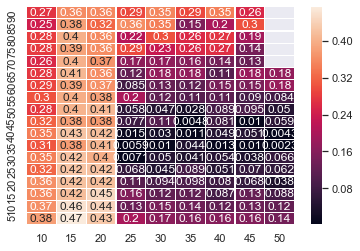

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
ax1 = sns.heatmap(precision_heatmap_df,annot=True,linewidths=0.1)
ax1.set_ylim([0,18])

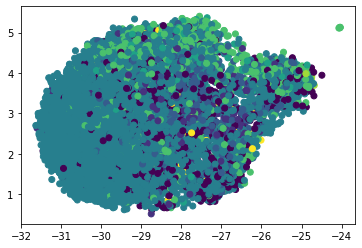

Number of Clusters: 
574


In [154]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=None,distance_threshold=0.5).fit(proteomeHD_embedding)
#clustering = DBSCAN(eps=0.25, min_samples=2).fit(proteomeHD_embedding)
total_clusters = len(np.unique(clustering.labels_))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(proteomeHD_embedding[:,0], proteomeHD_embedding[:,1], c=protein_organelle_categorical)
plt.show()

def get_cluster(cluster_num:int):
  return proteomeHD_embedding[np.where(clustering.labels_ == cluster_num)]

print("Number of Clusters: ")
print(total_clusters)
# for i in range(total_clusters):
#   print("Cluster {c_num}, number of genes: {g_num}".format(c_num=i,g_num=len(get_cluster(i))))

In [0]:
def get_cluster_genes(cluster_num:int):
  return proteomeHD_df.iloc[np.where(clustering.labels_ == cluster_num)[0].tolist(),1].to_numpy()

from itertools import chain, combinations
# Returns a list of all subsets of size lower to upper (inclusive)
def get_all_subsets(iterable,lower,upper):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(lower,upper+1)))

def is_validated(protein1,protein2,validation_source='corum'):
  if(validation_source=='corum'):
    for subunit in all_corum_subunits:
      if (protein1 in subunit and protein2 in subunit):
        #print(f"{protein1} and {protein2} in {subunit}")
        return 1
    return 0
  elif(validation_source=='huri'):
    for relation in huri_combined:
      if (protein1 in relation and protein2 in relation):
        #print(f"{protein1} and {protein2} in {relation}")
        return 1
    return 0
  else:
    return 0

def check_cluster_with_subset_size(cluster_genes,subset_size):
  subsets = get_all_subsets(cluster_genes,subset_size,subset_size)
  #print("Number of subsets of size {size} in this cluster: {num}".format(size=subset_size,num=len(subsets)))
  corum_hits = 0
  huri_hits = 0
  for subset in subsets:
    corum_hits += is_validated(subset[0],subset[1],'corum')
    huri_hits += is_validated(subset[0],subset[1],'huri')
  #print("Total subsets of size {size} corum hits: {num}".format(size=subset_size,num=corum_hits))
  #print("Total subsets of size {size} huri hits: {num}".format(size=subset_size,num=huri_hits))
  return corum_hits,huri_hits,corum_hits+huri_hits

In [0]:
get_cluster_genes(1)

array(['P18669', 'P61081', 'Q9NX63', 'Q9ULC4'], dtype=object)

In [0]:
import time
def get_top_clusters(top_n:int):
  start_time = time.time()
  all_cluster_hits = []
  for i in range(total_clusters):
    cluster_genes = get_cluster_genes(i)
    _,_,cluster_total_hits = check_cluster_with_subset_size(cluster_genes,2)
    #print(cluster_total_hits)
    cluster_hit_rate = cluster_total_hits / len(cluster_genes)
    all_cluster_hits.append((i,len(cluster_genes),cluster_total_hits,cluster_hit_rate))
    #print(all_cluster_hits)
    if i == 11:
      break
    if i % 100 == 0:
      print(f"currently checking cluster {i}")
  sorted(all_cluster_hits,key=lambda x:x[3],reverse=True)
  print(f"total time: {time.time() - start_time}")
  return all_cluster_hits[0:top_n-1]

In [0]:
get_top_clusters(10)

currently checking cluster 0
total time: 15.600077867507935


[(0, 28, 0, 0.0),
 (1, 23, 0, 0.0),
 (2, 33, 1, 0.030303030303030304),
 (3, 36, 0, 0.0),
 (4, 5, 0, 0.0),
 (5, 31, 0, 0.0),
 (6, 30, 0, 0.0),
 (7, 25, 0, 0.0),
 (8, 24, 1, 0.041666666666666664)]